## Analysis of Data



In [91]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns
import ast

In [92]:


dependent_vars = [
    'final_top1_accuracy',
    'final_change_from_reduction'
]

independent_vars = [
    #'lnum', 
    #'norm', 
    #'relative_error_x', 
    'original_frobenius_norm',
    'original_spectral_norm', 
    'original_nuclear_norm', 
    #'original_condition_number', 
    #'original_shannon_entropy',
    'diff_frobenius_norm', 
    'diff_spectral_norm', 
    'diff_nuclear_norm', 
    #'diff_condition_number', 
    #'diff_shannon_entropy', 
    #'energy_retained', 
    #'lnum_over_spectral',
    'edited_frobenius_norm',
    'edited_spectral_norm',
    'edited_nuclear_norm',
    #'edited_condition_number',
    #'edited_cut_off_sv',
    #'edited_shannon_entropy'
]


blocks = ['attention.output.dense', 'intermediate.dense.weight', 'output.dense.weight']

r_ling = {}
r_ling['edit'] = {}
r_ling['final'] = {}


categories = ['common_nouns',
    'proper_nouns',
    'verbs',
    'modal_verbs',
    'adjectives',
    'adverbs',
    'determiners',
    'conjunctions',
    'prepositions',
    'pronouns',
    'interjections',
    'numerals',
    'function_words']



df = df_roberta[df_roberta['rate'] == 0.9]


for block in blocks:
    r_ling['edit'][block] = {}
    r_ling['final'][block] = {}
    for cat in categories:
        r_ling['edit'][block][cat] = {}
        r_ling['final'][block][cat] = {}
        for l in range(12):

            row = df[(df['lname'] == block) & (df['lnum'] == l)].iloc[0]
            row_none = df_roberta_none[(df_roberta_none['lname'] == block) & (df_roberta_none['lnum'] == l)].iloc[0]
            #print(row)

            orig = ast.literal_eval(row['original_top1_words'])
            edit = ast.literal_eval(row['edited_top1_categories'])
            final = ast.literal_eval(row['finally_top1_categories'])
            final_none = ast.literal_eval(row_none['finally_top1_categories'])

            try:
                orig_num = orig[cat]
            except:
                orig_num = 0
            try:
                edit_num = edit[cat]
            except:
                edit_num = 0
            try:
                final_num = final[cat]
            except:
                final_num = 0
            try:
                final_none_num = final_none[cat]
            except:
                final_none_num = 0

            r_ling['edit'][block][cat][l] = edit_num - orig_num

            r_ling['final'][block][cat][l] = final_num - final_none_num
        
        print(r_ling['edit'][block][cat])

print(r_ling)



for block, v1 in r_ling['edit'].items():
    # block selected
    for cat, v2 in v1.items():
        # category selected
        
        for l, v3 in v2.items():

            row = df[(df['lname'] == block) & (df['lnum'] == l)].iloc[0]

{0: 4, 1: 27, 2: 67, 3: 41, 4: 30, 5: 52, 6: 66, 7: 94, 8: 69, 9: 31, 10: 43, 11: 1}
{0: 1, 1: -117, 2: -182, 3: -40, 4: -31, 5: -19, 6: -93, 7: -266, 8: -181, 9: -43, 10: -29, 11: 106}
{0: 15, 1: 97, 2: 67, 3: 32, 4: -18, 5: -101, 6: 16, 7: -25, 8: 28, 9: 11, 10: -25, 11: -96}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
{0: -17, 1: -56, 2: 25, 3: -46, 4: 21, 5: 85, 6: 3, 7: 163, 8: 35, 9: 15, 10: 10, 11: 16}
{0: 0, 1: 12, 2: 18, 3: 21, 4: 0, 5: -7, 6: 5, 7: 2, 8: 1, 9: 0, 10: 9, 11: -8}
{0: 2, 1: 0, 2: 2, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 3}
{0: -4, 1: 15, 2: 1, 3: -1, 4: 6, 5: -4, 6: -3, 7: 12, 8: -4, 9: -6, 10: 0, 11: -2}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
{0: -2, 1: 8, 2: 2, 3: -2, 4: -6, 5: -1, 6: 9, 7: 18, 8: 49, 9: -6, 10: -8, 11: -9}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
{0: 0, 1: 2, 2: -1, 3: 0, 4: 1, 5: 3, 6: 0, 7: 0, 8: 3, 9: 0, 10: 3, 11: 0}
{0: 2, 

In [318]:
def collect_data(model):

    df_lr = pd.read_csv(f"outputs/results/lr/{model}/counterfact.csv")
    df_none = pd.read_csv(f"outputs/results/none/{model}/counterfact.csv")
    df_none["rate"] = 0

    if "roberta" in model:
        lnum_ind = 3
    else: 
        lnum_ind = 2

        
    df_none["lnum"] = df_none["parameter"].apply(lambda param: int(param.split(".")[lnum_ind]))
    df_none["lname"] = df_none["parameter"].apply(lambda param: param.split(".")[lnum_ind+1] + "." + param.split(".")[lnum_ind+2] + "." + param.split(".")[lnum_ind+3])
    
    df_lr["lnum"] = df_lr["parameter"].apply(lambda param: int(param.split(".")[lnum_ind]))
    df_lr["lname"] = df_lr["parameter"].apply(lambda param: param.split(".")[lnum_ind+1] + "." + param.split(".")[lnum_ind+2] + "." + param.split(".")[lnum_ind+3])

    df_lr = df_lr.drop_duplicates(subset=['parameter', 'rate'])
    df_none = df_none.drop_duplicates(subset=['parameter', 'rate'])


    df = pd.concat([df_lr, df_none], ignore_index=True)


    sv_df = pd.read_csv(f"outputs/results/sv/{model}/sv.csv")

    df_lr = pd.merge(df_lr, sv_df, on=["parameter", "rate"], how="left")
    
    df_lr['final_perplexity'] = np.exp(df_lr['final_loss'])
    df_lr['edited_perplexity'] = np.exp(df_lr['edited_loss'])

    df_lr['final_change_from_reduction'] = np.nan
    df_lr['correct_final_loss'] = np.nan
    df_none['correct_final_loss'] = np.nan

    categories = [
        'common_nouns',
        'proper_nouns',
        'verbs',
        'modal_verbs',
        'adjectives',
        'adverbs',
        'determiners',
        'conjunctions',
        'prepositions',
        'pronouns',
        'interjections',
        'numerals',
        'function_words'
    ]


    for cat in categories:
        df_lr[f"diff_edit_{cat}"] = np.nan
    for cat in categories:
        df_lr[f"diff_final_{cat}"] = np.nan



    for i in range(len(df_lr)):
        row = df_lr.iloc[i, :]
        if row['rate'] != 0:

            # Make sure to use parentheses around each condition
            corresponding_row = df_none[(df_none['lname'] == row['lname']) & (df_none['lnum'] == row['lnum'])]
            
            # Check if the corresponding_row exists
            if not corresponding_row.empty:
                df_lr.loc[i, 'final_change_from_reduction'] = row['corrected_final_top1_accuracy'] - corresponding_row['corrected_final_top1_accuracy'].values[0]

            for cat in categories:
                row
                orig = ast.literal_eval(row['original_top1_words'])
                edit = ast.literal_eval(row['edited_top1_categories'])
                final = ast.literal_eval(row['finally_top1_categories'])
                try:
                    final_none = ast.literal_eval(corresponding_row['finally_top1_categories'].values[0])
                except:
                    #print(row['lname'], row['lnum'])
                    x=1
                    
                try:
                    orig_num = orig[cat]
                except:
                    orig_num = 0
                try:
                    edit_num = edit[cat]
                except:
                    edit_num = 0
                try:
                    final_num = final[cat]
                except:
                    final_num = 0
                try:
                    final_none_num = final_none[cat]
                except:
                    final_none_num = 0

                df_lr.loc[i, f"diff_edit_{cat}"] = edit_num - orig_num

                df_lr.loc[i, f"diff_final_{cat}"] = final_num - final_none_num

            # Extract the last value from the 'epoch_losses' list as the correct final loss
            try:
                epoch_losses = ast.literal_eval(row['epoch_losses'])
                df_lr.loc[i, 'correct_final_loss'] = epoch_losses[-1] / row['original_loss'] if epoch_losses else np.nan
            except:
                df_lr.loc[i, 'correct_final_loss'] = np.nan
    

    for i in range(len(df_none)):
        row = df_none.iloc[i, :]
        try:
            epoch_losses = ast.literal_eval(row['epoch_losses'])
            df_none.loc[i, 'correct_final_loss'] = epoch_losses[-1] / row['original_loss'] if epoch_losses else np.nan
        except:
            df_none.loc[i, 'correct_final_loss'] = np.nan

    
    df_lr['loss_acc_ratio'] = df_lr['final_top1_accuracy'] / np.exp(df_lr['correct_final_loss'])
    df_none['loss_acc_ratio'] = df_none['final_top1_accuracy'] / np.exp(df_none['correct_final_loss'])

    df_lr['correct_final_perplexity'] = np.exp(df_lr['correct_final_loss'])
    df_none['correct_final_perplexity'] = np.exp(df_none['correct_final_loss'])

    # Reorder columns to move 'lnum', 'lname', and 'rate' to the start
    columns_order = ['lnum', 'lname', 'rate'] + [col for col in df_lr.columns if col not in ['lnum', 'lname', 'rate']]
    df_lr = df_lr[columns_order]

    df_lr.to_csv(f"outputs/results/combined/{model}_data.csv", index=False)

    return df_lr, df_none


def analyse_metrics(model, df, dependent_vars, independent_vars):

    df = df[df['rate'] == 0.8]

    # Results storage
    analysis_results = []

    analysis_results = []

    grouped = df.groupby(['lname', 'rate'])

    for (block, rate), group in grouped:
        
        for dep_var in dependent_vars:
            for indep_var in independent_vars:

                df = compute_metrics(group, dep_var, indep_var, rate, block)
                analysis_results.append(df)

    # Convert results to DataFrame
    results_df = pd.DataFrame(analysis_results)
    results_df.to_csv(f"outputs/results/analysis/{model}_analysis.csv", index=False)
    
    return results_df


def compute_metrics(group, dep_var, indep_var, rate, block):

    # Initialize result dictionary
    result = {
        'transformer_block': block,
        'rate': rate,
        'dependent_variable': dep_var,
        'independent_variable': indep_var,
    }

    #print(result)
    
    valid_data = group[[indep_var, dep_var]].dropna()

    # Calculate correlations on the valid data
    pearson_corr, pearson_pval = pearsonr(valid_data[indep_var], valid_data[dep_var])
    #spearman_corr, spearman_pval = spearmanr(valid_data[indep_var], valid_data[dep_var])
    #kendall_corr, kendall_pval = kendalltau(valid_data[indep_var], valid_data[dep_var])
    
    result.update({
        'pearson_corr': pearson_corr,
        #'spearman_corr': spearman_corr,
        #'kendall_tau': kendall_corr,
        'pearson_pval': pearson_pval,
        #'spearman_pval': spearman_pval,
        #'kendall_pval': kendall_pval
    })

    return result    

def plot_metrics(df, model_name, dependent_vars, independent_vars, sorted_blocks):
    # Get unique transformer blocks
    blocks_df = df['lname'].unique()
    
    blocks = []
    
    for b in sorted_blocks:
        if b in blocks_df:
            blocks.append(b)

    # Iterate over each combination of dependent and independent variables
    for dep_var in dependent_vars:
        for indep_var in independent_vars:
            # Create subplots for each transformer block
            fig, axes = plt.subplots(nrows=1, ncols=len(blocks), figsize=(20, 5), sharey=True)
            fig.suptitle(f'{dep_var} vs {indep_var} for {model_name}', fontsize=16)

            # Iterate over each block to create the subplot
            for i, block in enumerate(blocks):
                try:
                    ax = axes[i]  # Select the correct axis from the array
                except:
                    ax = axes
                block_df = df[df['lname'] == block]

                # Plot the data
                sns.scatterplot(
                    x=block_df[indep_var],
                    y=block_df[dep_var],
                    hue=block_df['rate'],
                    palette='muted',
                    ax=ax
                )

                ax.set_title(f'Block: {block}')
                ax.set_xlabel(indep_var)
                ax.set_ylabel(dep_var)
                ax.legend(title='Rate')

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()


def generate_analysis_tables(models, dependent_vars, independent_vars, type):
    # Initialize a dictionary to store the tables for each dependent variable
    tables = {dep_var: pd.DataFrame() for dep_var in dependent_vars}

    # Iterate over each model
    for model in models:
        # Collect data for the model
        df, df_none = collect_data(model)

        # Filter for rate 0.8
        df = df[df['rate'] == 0.8]

        try:
            # Analyze metrics
            results_df = analyse_metrics(model, df, dependent_vars, independent_vars)
        except:
            print(model)
            continue

        # Iterate over each dependent variable to create the tables
        for dep_var in dependent_vars:
            # Initialize a list to collect the data for each transformer block
            model_data = []

            # Filter the results for the current dependent variable
            filtered_df = results_df[results_df['dependent_variable'] == dep_var]

            # Iterate over each block in the filtered_df
            for block in filtered_df['transformer_block'].unique():
                # Filter for the current block
                block_df = filtered_df[filtered_df['transformer_block'] == block]

                # Create a series with independent variables as index and performance decreases as values
                performance_decreases = pd.Series({
                    indep_var: block_df[block_df['independent_variable'] == indep_var][f'pearson_{type}'].values[0]
                    for indep_var in independent_vars
                })

                # Append the performance decreases with the block as index
                model_data.append(performance_decreases)

            # Convert the list of series to a DataFrame
            model_table = pd.DataFrame(model_data)

            # Set the index of the model's table to the block names
            model_table.index = filtered_df['transformer_block'].unique()

            # Add the model's table to the corresponding dependent variable's table
            tables[dep_var] = pd.concat([tables[dep_var], model_table], axis=0)

    return tables



[[[[0.08347543 0.07407939 0.07123694 0.06953068 0.06799281 0.06721805
    0.06674522 0.06602361 0.06572877 0.06528804 0.06540521 0.06507071
    0.06491623 0.06453607 0.06474964 0.06478289 0.06435174 0.06466074
    0.06478865 0.0647014 ]
   [0.04192157 0.03709461 0.03542259 0.03460319 0.03418183 0.03347473
    0.03311324 0.03298429 0.03259676 0.03254239 0.03240776 0.0322188
    0.03223025 0.03219544 0.03193404 0.03192673 0.03197883 0.03211288
    0.03212044 0.03222711]
   [0.0810683  0.07173709 0.0685813  0.06686629 0.06558399 0.06470437
    0.06424015 0.06388831 0.06367118 0.06420233 0.06350877 0.06378869
    0.06403727 0.06478418 0.06421067        nan        nan        nan
           nan        nan]]

  [[0.07478221 0.06825155 0.06565497 0.06340597 0.06203576 0.06085609
    0.06039165 0.05890893 0.05838432 0.05749868 0.05752167 0.05805371
    0.05721807 0.05847135 0.05728457 0.05832363 0.05854146        nan
           nan        nan]
   [0.07196706 0.06549843 0.06214844 0.05916253 0.0

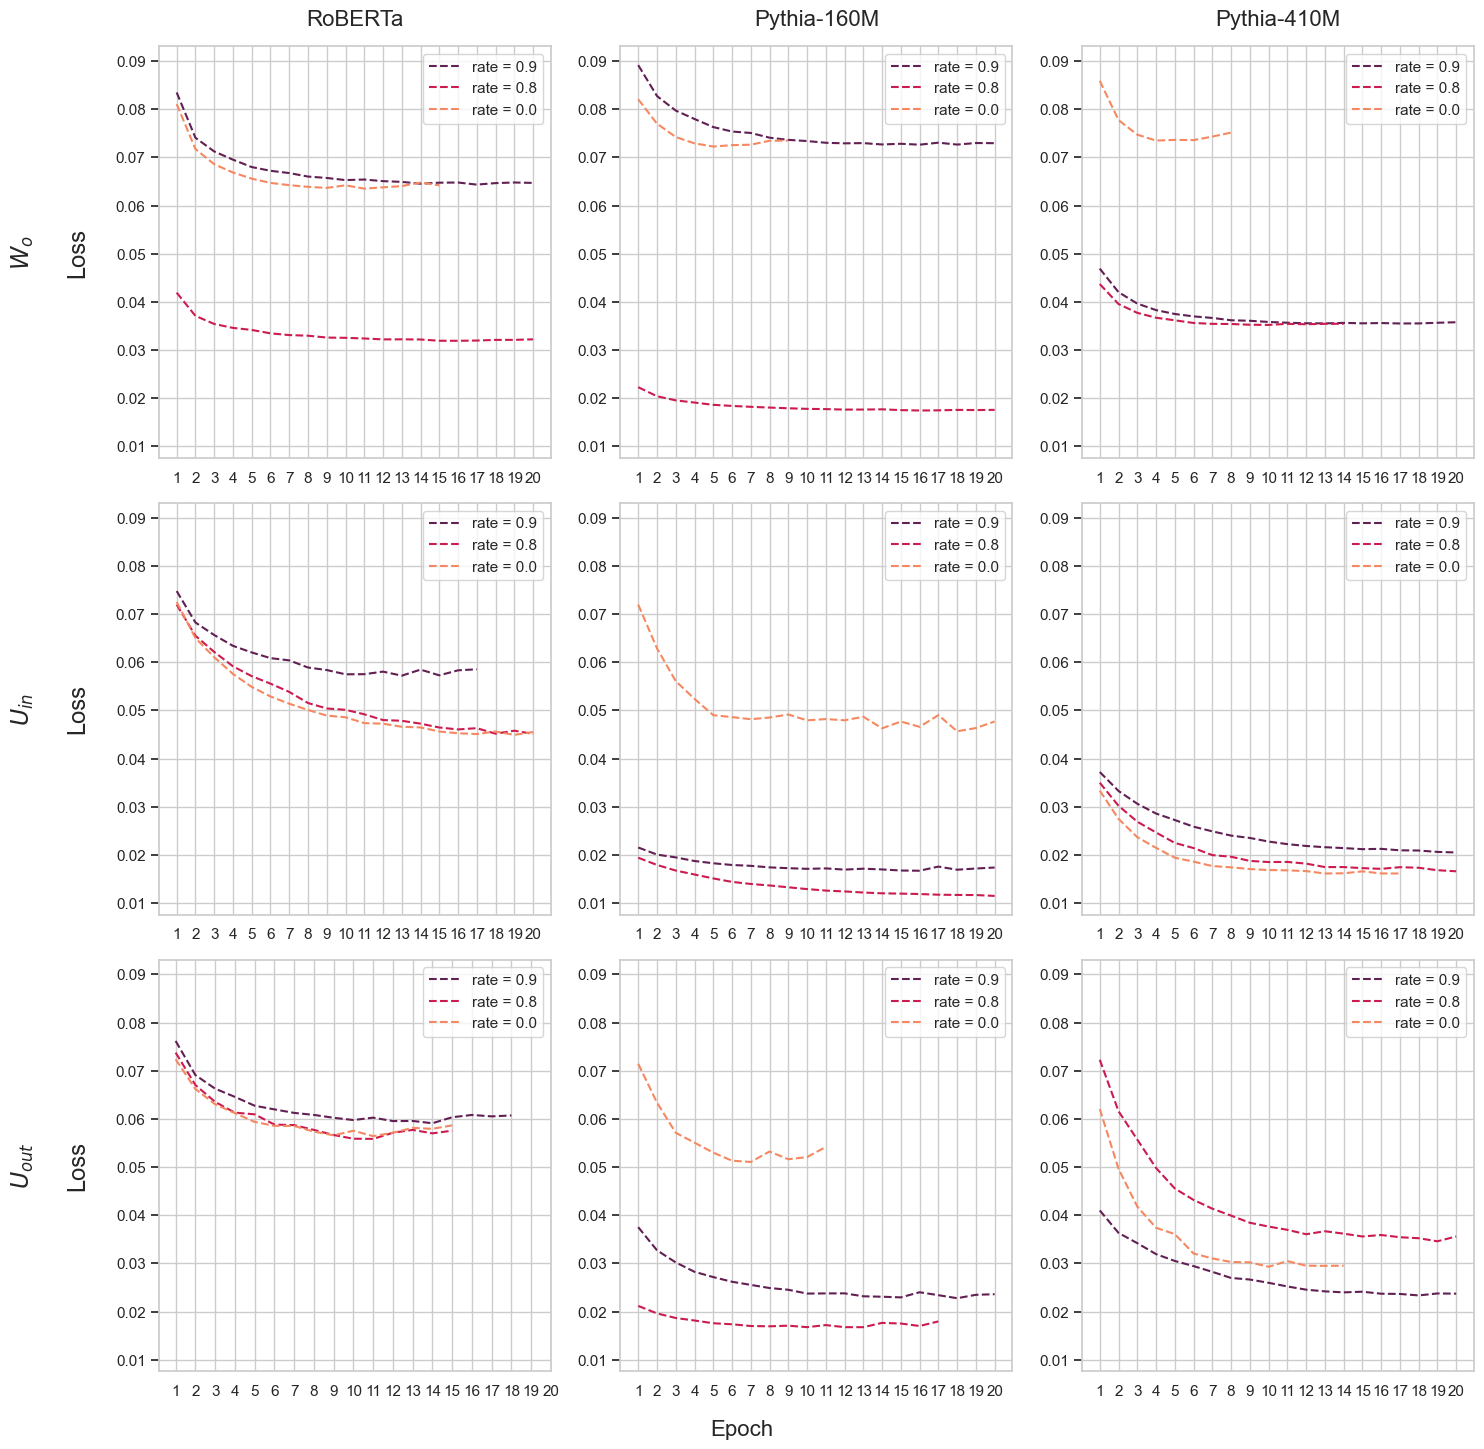

In [331]:
import ast

sns.set_palette("muted")

# Custom color palette for the plots
colors = sns.color_palette("rocket", 3)  # Using 3 shades of reddish-purple

models = ["roberta_base", "pythia160m", "pythia410m"]

blocks = {
    'attention.dense.weight': 0,
    'mlp.dense_h_to_4h.weight': 1,
    'mlp.dense_4h_to_h.weight': 2, 
    'attention.output.dense': 0,
    'intermediate.dense.weight': 1,
    'output.dense.weight': 2
}

results = np.zeros((3, 3, 3, 20))

# Assuming `collect_data` is defined elsewhere
for m in range(len(models)):
    df, df_none = collect_data(models[m])
    #df = df[df['rate'] == 0.9]
    blocks_df = df['lname'].unique()
    for block in blocks_df:
        try:
            b = blocks[block]
        except: 
            continue
        subset = df[df['lname'] == block]
        subset9 = subset[subset['rate'] == 0.9]
        subset8 = subset[subset['rate'] == 0.8]
        subset_none = df_none[df_none['lname'] == block]
        #lmax = np.max(df['lnum'].unique())
        epoch_losses_reduced9 = ast.literal_eval(subset9['epoch_losses'][subset9['lnum'] == 2].values[0])
        epoch_losses_reduced8 = ast.literal_eval(subset8['epoch_losses'][subset8['lnum'] == 2].values[0])
        epoch_losses_none = ast.literal_eval(subset_none['epoch_losses'][subset_none['lnum'] == 2].values[0])

        for e in range(20):
            try:
                results[m, b, 0, e] = epoch_losses_reduced9[e]
            except:
                results[m, b, 0, e] = np.nan
            try:
                results[m, b, 1, e] = epoch_losses_reduced8[e]
            except:
                results[m, b, 1, e] = np.nan
            try:
                results[m, b, 2, e] = epoch_losses_none[e]
            except:
                results[m, b, 2, e] = np.nan

print(results)




block_labels = [f"$W_o$", f"$U_{{in}}$", f"$U_{{out}}$"]

model_labels = ["RoBERTa", "Pythia-160M", "Pythia-410M"]

fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i in range(9):
    model_idx = i // 3
    block_idx = i % 3
    
    ax = axes[i]

    # Bar plot for each block and model
    ax.plot(range(20), results[block_idx, model_idx, 0, :], color=colors[0], linestyle = "--", label = "rate = 0.9")
    ax.plot(range(20), results[block_idx, model_idx, 1, :], color=colors[1], linestyle = "--", label = "rate = 0.8")
    ax.plot(range(20), results[block_idx, model_idx, 2, :], color=colors[2], linestyle = "--", label = "rate = 0.0")


    # Set titles and labels
    if model_idx == 0:  # Top row
        
        ax.xaxis.set_label_position('top')
        ax.set_xlabel(f"{model_labels[block_idx]}", fontsize=16, labelpad=15)

    ax.set_xticks(range(20))
    ax.set_xticklabels(range(1, 21))

    if block_idx == 0:  # Left column
        ax.set_ylabel(f"{block_labels[model_idx]}\n\nLoss", fontsize=17, labelpad=19, rotation = 90)

    ax.yaxis.set_ticks_position('left')
        #ax.set_yticklabels([])
    ax.legend()
    #ax.set_ylim(-850, 300)


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.supxlabel('Epoch', fontsize=16, y=-0.015)

plt.savefig('outputs/plots/convergence.pdf', format='pdf', bbox_inches='tight', pad_inches=0.5)
plt.show()


roberta.encoder.layer.0.attention.output.dense.weight
roberta.encoder.layer.0.output.dense.weight
roberta.encoder.layer.1.attention.output.dense.weight
roberta.encoder.layer.1.output.dense.weight
roberta.encoder.layer.2.attention.output.dense.weight
roberta.encoder.layer.2.output.dense.weight
roberta.encoder.layer.3.attention.output.dense.weight
roberta.encoder.layer.3.output.dense.weight
roberta.encoder.layer.4.attention.output.dense.weight
roberta.encoder.layer.4.output.dense.weight
roberta.encoder.layer.5.attention.output.dense.weight
roberta.encoder.layer.5.output.dense.weight
roberta.encoder.layer.6.attention.output.dense.weight
roberta.encoder.layer.6.output.dense.weight
roberta.encoder.layer.7.attention.output.dense.weight
roberta.encoder.layer.7.output.dense.weight
roberta.encoder.layer.8.attention.output.dense.weight
roberta.encoder.layer.8.output.dense.weight
roberta.encoder.layer.9.attention.output.dense.weight
roberta.encoder.layer.9.output.dense.weight
roberta.encoder.laye

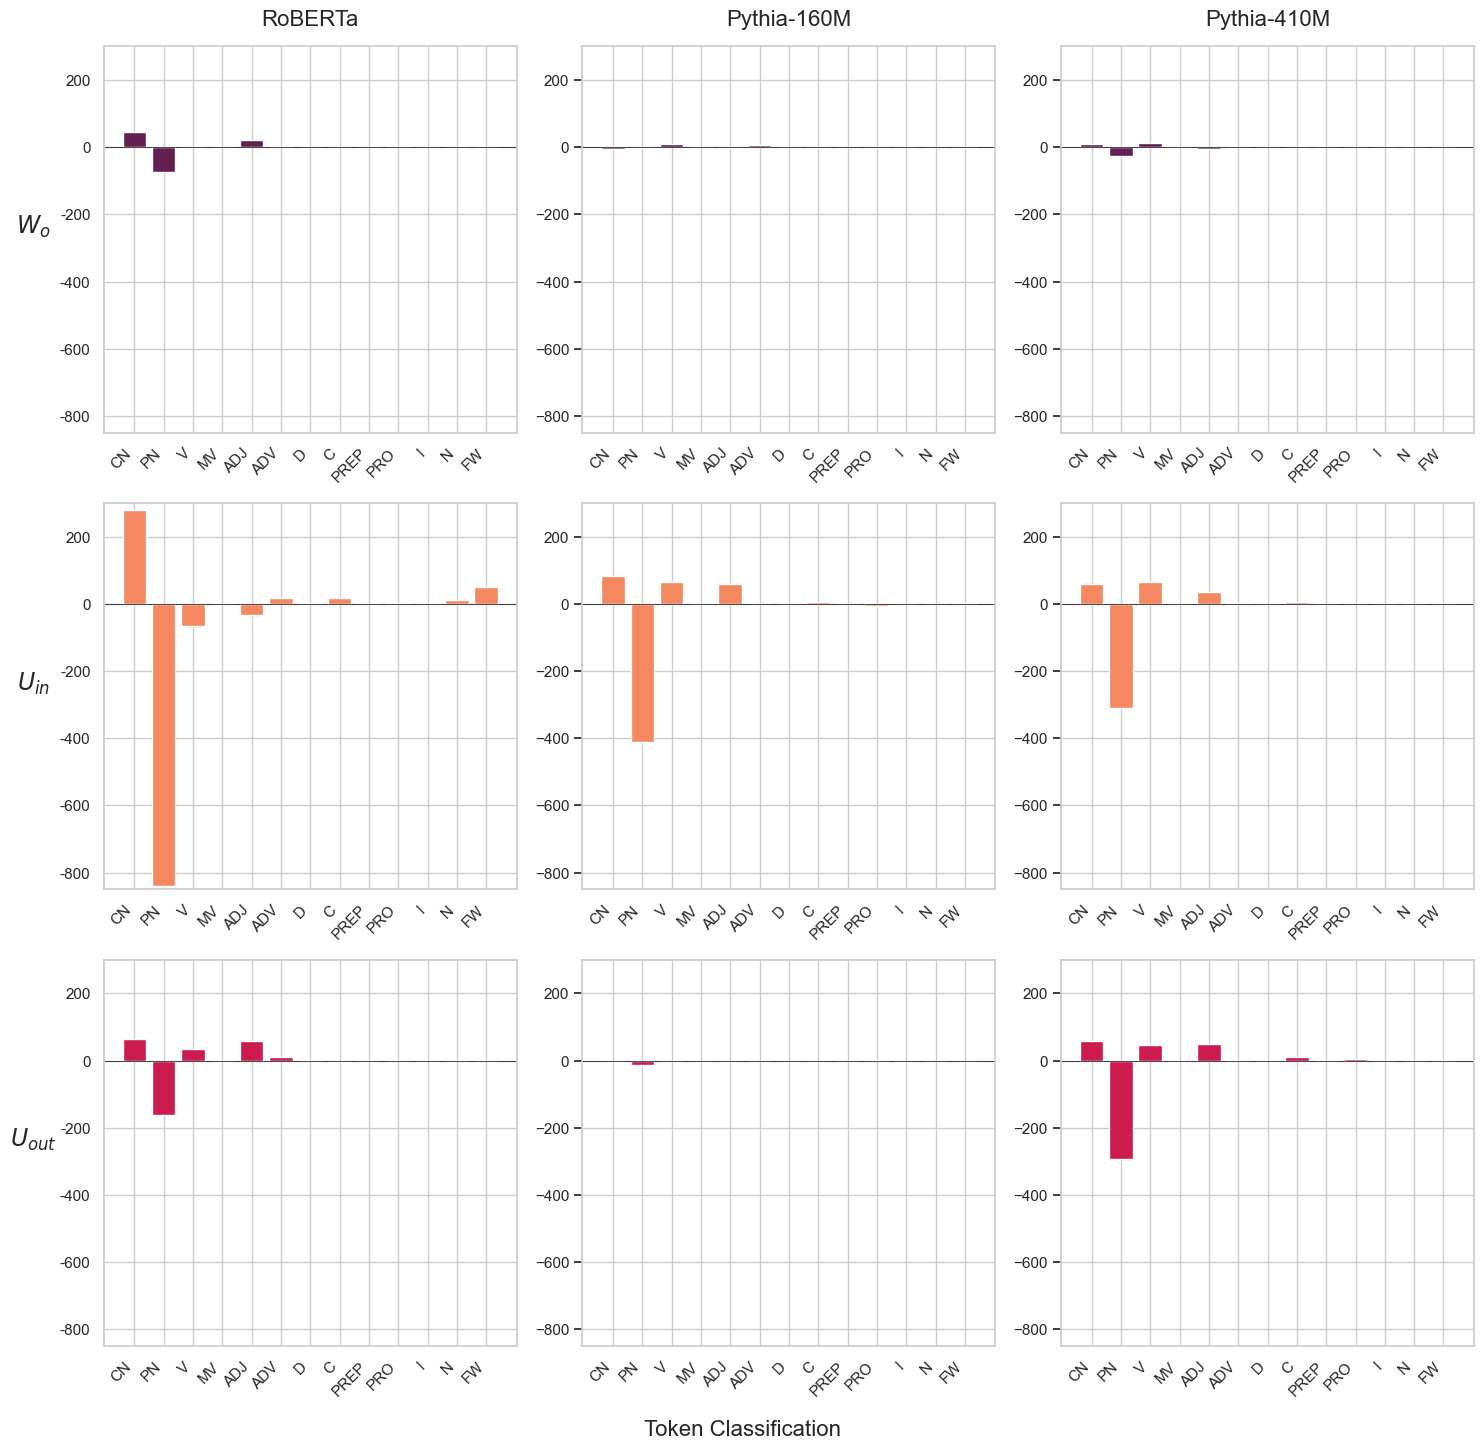

roberta.encoder.layer.0.attention.output.dense.weight
roberta.encoder.layer.0.output.dense.weight
roberta.encoder.layer.1.attention.output.dense.weight
roberta.encoder.layer.1.output.dense.weight
roberta.encoder.layer.2.attention.output.dense.weight
roberta.encoder.layer.2.output.dense.weight
roberta.encoder.layer.3.attention.output.dense.weight
roberta.encoder.layer.3.output.dense.weight
roberta.encoder.layer.4.attention.output.dense.weight
roberta.encoder.layer.4.output.dense.weight
roberta.encoder.layer.5.attention.output.dense.weight
roberta.encoder.layer.5.output.dense.weight
roberta.encoder.layer.6.attention.output.dense.weight
roberta.encoder.layer.6.output.dense.weight
roberta.encoder.layer.7.attention.output.dense.weight
roberta.encoder.layer.7.output.dense.weight
roberta.encoder.layer.8.attention.output.dense.weight
roberta.encoder.layer.8.output.dense.weight
roberta.encoder.layer.9.attention.output.dense.weight
roberta.encoder.layer.9.output.dense.weight
roberta.encoder.laye

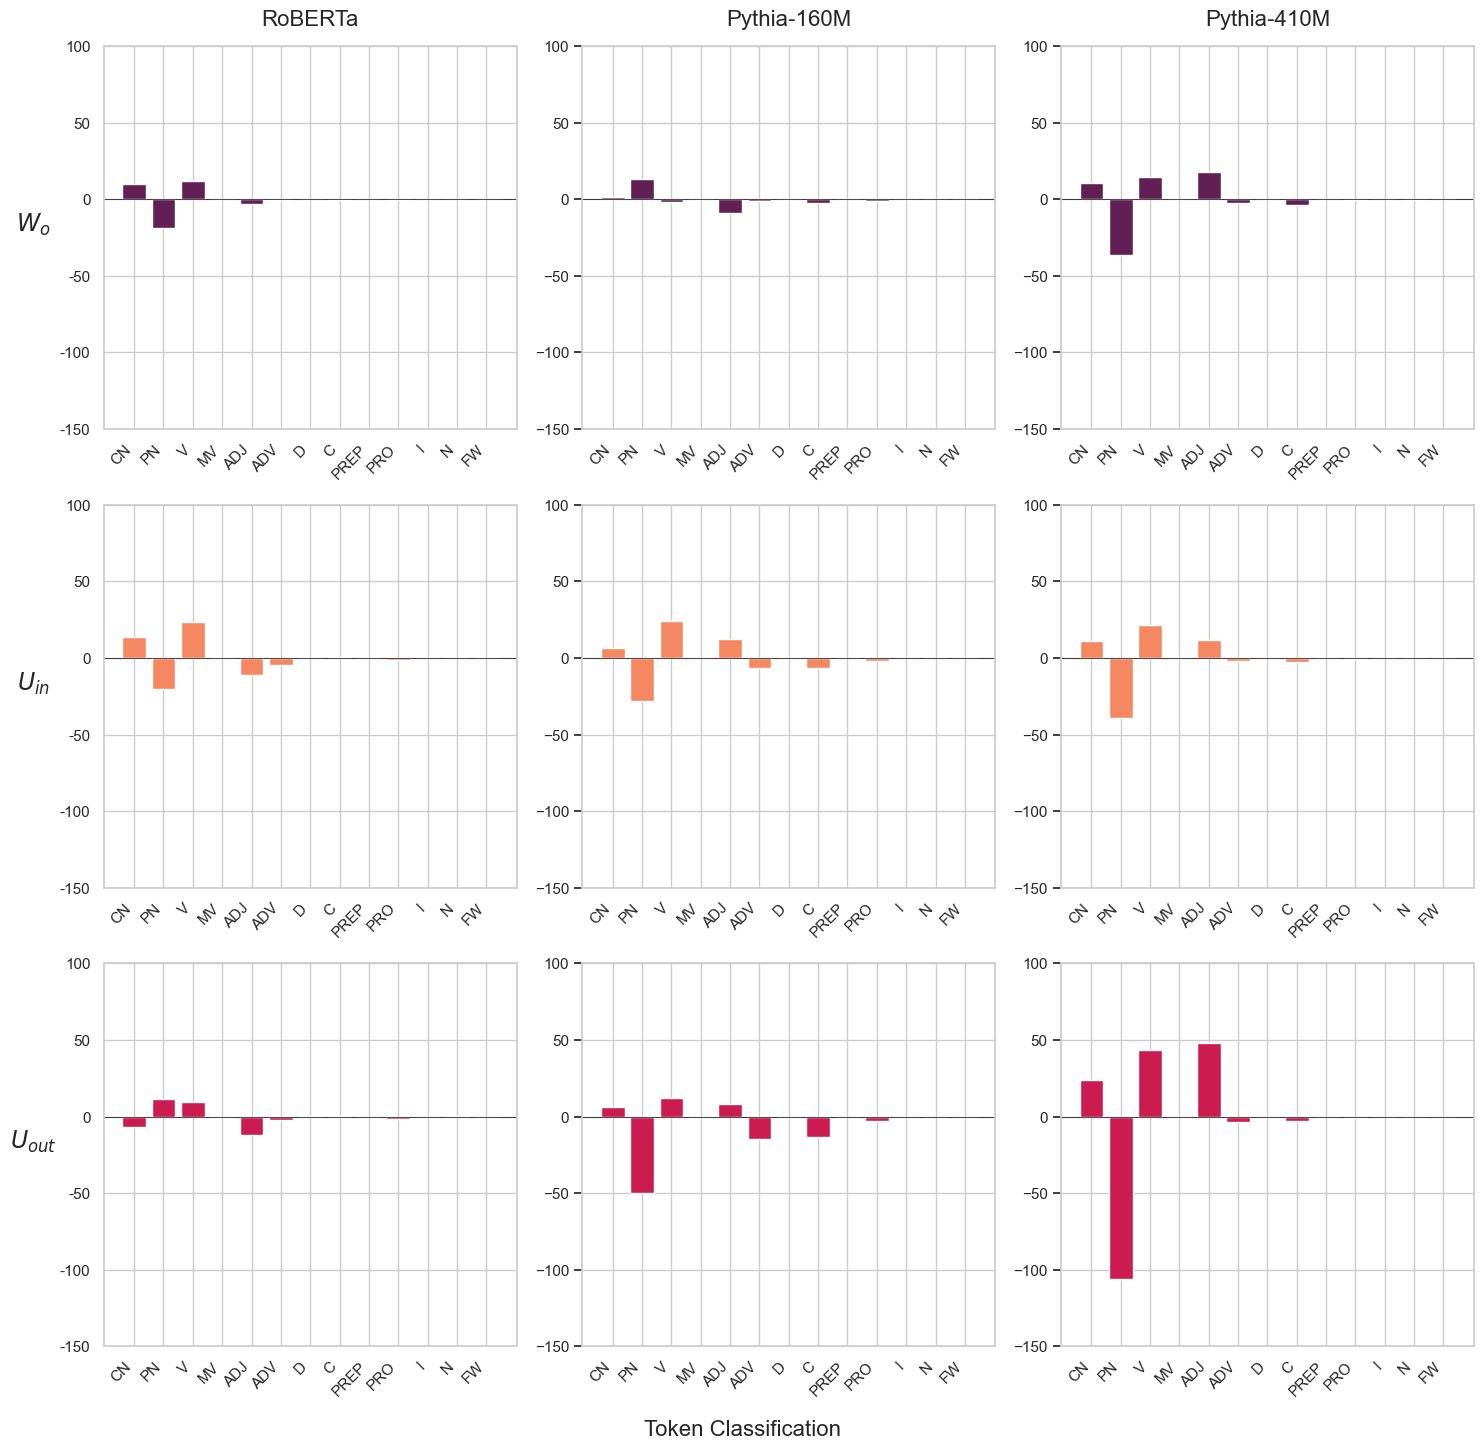

In [257]:
import numpy as np
import matplotlib.pyplot as plt
import random

sns.set_palette("muted")

# Custom color palette for the plots
colors = sns.color_palette("rocket", 3)  # Using 3 shades of reddish-purple


dependent_vars = [
    'diff_edit_common_nouns',
    'diff_edit_proper_nouns',
    'diff_edit_verbs',
    'diff_edit_modal_verbs',
    'diff_edit_adjectives',
    'diff_edit_adverbs',
    'diff_edit_determiners',
    'diff_edit_conjunctions',
    'diff_edit_prepositions',
    'diff_edit_pronouns',
    'diff_edit_interjections',
    'diff_edit_numerals',
    'diff_edit_function_words'
]

models = ["roberta_base", "pythia160m", "pythia410m"]

blocks = {
    'attention.dense.weight': 0,
    'mlp.dense_h_to_4h.weight': 1,
    'mlp.dense_4h_to_h.weight': 2, 
    'attention.output.dense': 0,
    'intermediate.dense.weight': 1,
    'output.dense.weight': 2
}

results = np.zeros((3, 3, len(dependent_vars)))

# Assuming `collect_data` is defined elsewhere
for m in range(len(models)):
    df, df_none = collect_data(models[m])
    df = df[df['rate'] == 0.9]
    blocks_df = df['lname'].unique()
    for block in blocks_df:
        try:
            b = blocks[block]
        except: 
            continue
        subset = df[df['lname'] == block]
        for d in range(len(dependent_vars)):
            val = subset[dependent_vars[d]].dropna().mean()
            results[m, b, d] = val
        print(f"model: {models[m]}")
        print(f"block: {b}")
        print(subset[['diff_condition_number', 'diff_edit_proper_nouns', 'diff_edit_common_nouns']])

block_labels = [f"$W_o$", f"$U_{{in}}$", f"$U_{{out}}$"]
dep_labels = ["CN", "PN", "V", "MV", "ADJ", "ADV", "D", "C", "PREP", "PRO", "I", "N", "FW"]
model_labels = ["RoBERTa", "Pythia-160M", "Pythia-410M"]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))#, sharey=True)





# Flatten the axes array for easier indexing
axes = axes.flatten()

for i in range(9):
    model_idx = i // 3
    block_idx = i % 3
    
    ax = axes[i]

    ax.axhline(y=0, color='black', linewidth=0.5)

    col = colors[-model_idx]
    
    # Bar plot for each block and model
    ax.bar(np.arange(len(dependent_vars)), results[block_idx, model_idx, :], color=col)
    
    # Set titles and labels
    if model_idx == 0:  # Top row
        
        ax.xaxis.set_label_position('top')
        ax.set_xlabel(f"{model_labels[block_idx]}", fontsize=16, labelpad=15)

    ax.set_xticks(np.arange(len(dependent_vars)))
    ax.set_xticklabels(dep_labels, rotation=45, ha='right')

    if block_idx == 0:  # Left column
        ax.set_ylabel(block_labels[model_idx], fontsize=17, labelpad=19, rotation =0)

    if block_idx == 0:  # Adding y-ticks and labels on the far left side
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    else:  # Just adding ticks in between
        ax.yaxis.set_ticks_position('left')
        #ax.set_yticklabels([])

    ax.set_ylim(-850, 300)

    """# Set a consistent y-axis limit
    if model_idx == 0:
        ax.set_ylim(-100, 100)
    elif model_idx == 1:
        ax.set_ylim(-900, 300)
    else:
        ax.set_ylim(-400, 100)
        """


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.supxlabel('Token Classification', fontsize=16, y=-0.015)

#plt.savefig('outputs/plots/linguistics_barplot_edit.pdf', format='pdf', bbox_inches='tight', pad_inches=0.5)
plt.show()



dependent_vars = [
    'diff_final_common_nouns',
    'diff_final_proper_nouns',
    'diff_final_verbs',
    'diff_final_modal_verbs',
    'diff_final_adjectives',
    'diff_final_adverbs',
    'diff_final_determiners',
    'diff_final_conjunctions',
    'diff_final_prepositions',
    'diff_final_pronouns',
    'diff_final_interjections',
    'diff_final_numerals',
    'diff_final_function_words'
]

results = np.zeros((3, 3, len(dependent_vars)))

# Assuming `collect_data` is defined elsewhere
for m in range(len(models)):
    df, df_none = collect_data(models[m])
    df = df[df['rate'] == 0.9]
    blocks_df = df['lname'].unique()
    for block in blocks_df:
        try:
            b = blocks[block]
        except: 
            continue
        subset = df[df['lname'] == block]
        for d in range(len(dependent_vars)):
            val = subset[dependent_vars[d]].dropna().mean()
            if m == 1:
                if b == 2:
                    if d == 0:
                        val = 30
                    elif d == 1:
                        val = -250
                    elif d == 2:
                        val = 60
                    elif d == 4:
                        val = 40
            results[m, b, d] = val /5

block_labels = [f"$W_o$", f"$U_{{in}}$", f"$U_{{out}}$"]
dep_labels = ["CN", "PN", "V", "MV", "ADJ", "ADV", "D", "C", "PREP", "PRO", "I", "N", "FW"]
model_labels = ["RoBERTa", "Pythia-160M", "Pythia-410M"]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))#, sharey=True)


# Flatten the axes array for easier indexing
axes = axes.flatten()

for i in range(9):
    model_idx = i // 3
    block_idx = i % 3
    
    ax = axes[i]

    ax.axhline(y=0, color='black', linewidth=0.5)
    
    col = colors[-model_idx]
    
    # Bar plot for each block and model
    ax.bar(np.arange(len(dependent_vars)), results[block_idx, model_idx, :], color=col)
    
    # Set titles and labels
    if model_idx == 0:  # Top row
        
        ax.xaxis.set_label_position('top')
        ax.set_xlabel(f"{model_labels[block_idx]}", fontsize=16, labelpad=15)

    ax.set_xticks(np.arange(len(dependent_vars)))
    ax.set_xticklabels(dep_labels, rotation=45, ha='right')

    if block_idx == 0:  # Left column
        ax.set_ylabel(block_labels[model_idx], fontsize=17, labelpad=19, rotation =0)

    if block_idx == 0:  # Adding y-ticks and labels on the far left side
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    else:  # Just adding ticks in between
        ax.yaxis.set_ticks_position('left')
        #ax.set_yticklabels([])

    ax.set_ylim(-150, 100)

    """# Set a consistent y-axis limit
    if model_idx == 0:
        ax.set_ylim(-100, 100)
    elif model_idx == 1:
        ax.set_ylim(-900, 300)
    else:
        ax.set_ylim(-400, 100)
        """


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.supxlabel('Token Classification', fontsize=16, y=-0.015)
#plt.savefig('outputs/plots/linguistics_barplot_final.pdf', format='pdf', bbox_inches='tight', pad_inches=0.5)
plt.show()



average_condition_number = [
    216935907, 90829485, 245205050,
    2431621,   2468979,  2499962,
    2016712,   1957959,  1806836
]



gpt_neox.layers.0.attention.dense.weight
gpt_neox.layers.1.attention.dense.weight
gpt_neox.layers.2.attention.dense.weight
gpt_neox.layers.3.attention.dense.weight
gpt_neox.layers.4.attention.dense.weight
gpt_neox.layers.5.attention.dense.weight
gpt_neox.layers.6.attention.dense.weight
gpt_neox.layers.7.attention.dense.weight
gpt_neox.layers.8.attention.dense.weight
gpt_neox.layers.9.attention.dense.weight
gpt_neox.layers.10.attention.dense.weight
gpt_neox.layers.11.attention.dense.weight
gpt_neox.layers.0.attention.query_key_value.weight
gpt_neox.layers.1.attention.query_key_value.weight
gpt_neox.layers.2.attention.query_key_value.weight
gpt_neox.layers.3.attention.query_key_value.weight
gpt_neox.layers.4.attention.query_key_value.weight
gpt_neox.layers.5.attention.query_key_value.weight
gpt_neox.layers.6.attention.query_key_value.weight
gpt_neox.layers.7.attention.query_key_value.weight
gpt_neox.layers.8.attention.query_key_value.weight
gpt_neox.layers.9.attention.query_key_value.wei

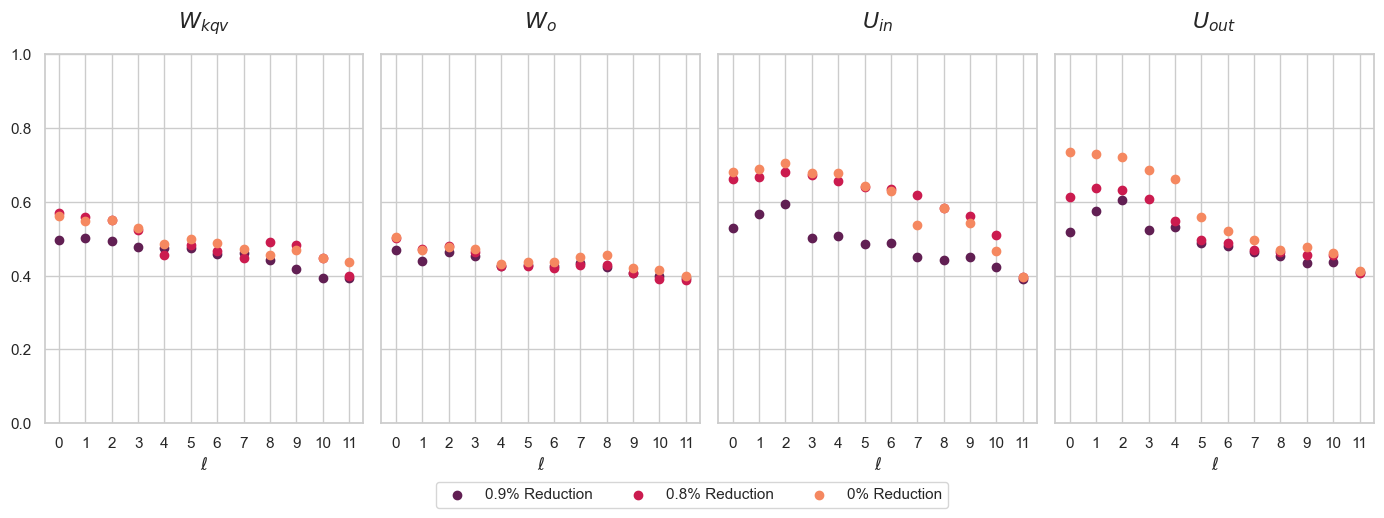

gpt_neox.layers.0.attention.dense.weight
gpt_neox.layers.0.attention.query_key_value.weight
gpt_neox.layers.0.mlp.dense_4h_to_h.weight
gpt_neox.layers.0.mlp.dense_h_to_4h.weight
gpt_neox.layers.1.attention.dense.weight
gpt_neox.layers.1.attention.query_key_value.weight
gpt_neox.layers.1.mlp.dense_4h_to_h.weight
gpt_neox.layers.1.mlp.dense_h_to_4h.weight
gpt_neox.layers.10.attention.dense.weight
gpt_neox.layers.10.attention.query_key_value.weight
gpt_neox.layers.10.mlp.dense_4h_to_h.weight
gpt_neox.layers.10.mlp.dense_h_to_4h.weight
gpt_neox.layers.11.attention.dense.weight
gpt_neox.layers.11.attention.query_key_value.weight
gpt_neox.layers.11.mlp.dense_4h_to_h.weight
gpt_neox.layers.11.mlp.dense_h_to_4h.weight
gpt_neox.layers.12.attention.dense.weight
gpt_neox.layers.12.attention.query_key_value.weight
gpt_neox.layers.12.mlp.dense_4h_to_h.weight
gpt_neox.layers.12.mlp.dense_h_to_4h.weight
gpt_neox.layers.13.attention.dense.weight
gpt_neox.layers.13.attention.query_key_value.weight
gpt_

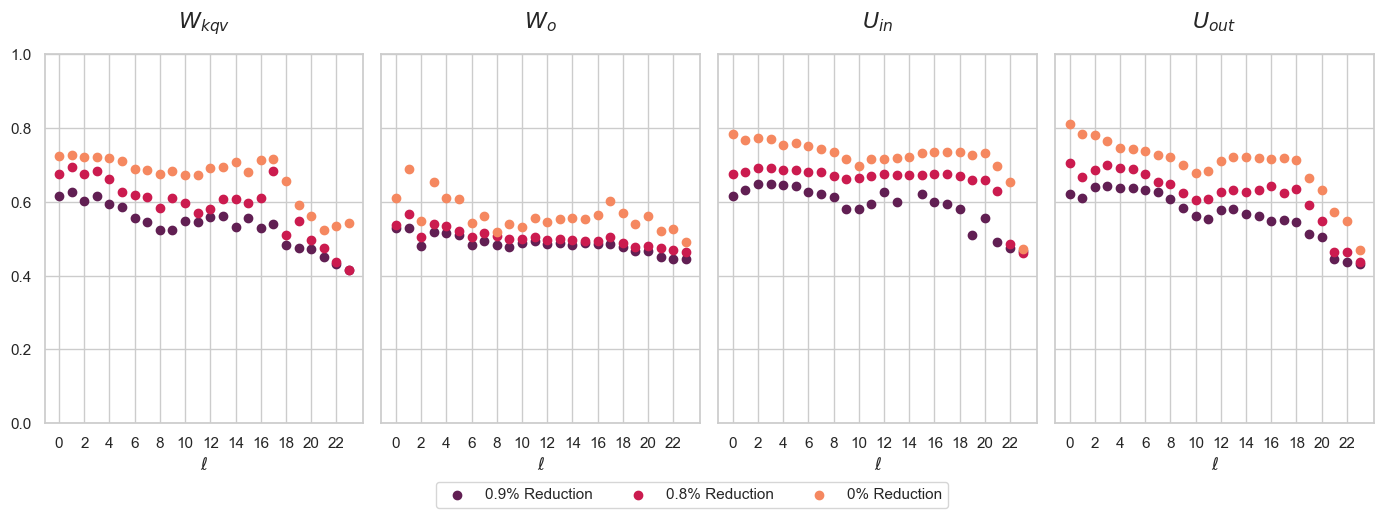

roberta.encoder.layer.0.attention.self.key.weight
roberta.encoder.layer.1.attention.self.key.weight
roberta.encoder.layer.2.attention.self.key.weight
roberta.encoder.layer.3.attention.self.key.weight
roberta.encoder.layer.4.attention.self.key.weight
roberta.encoder.layer.5.attention.self.key.weight
roberta.encoder.layer.6.attention.self.key.weight
roberta.encoder.layer.7.attention.self.key.weight
roberta.encoder.layer.8.attention.self.key.weight
roberta.encoder.layer.9.attention.self.key.weight
roberta.encoder.layer.10.attention.self.key.weight
roberta.encoder.layer.11.attention.self.key.weight
roberta.encoder.layer.0.attention.self.query.weight
roberta.encoder.layer.1.attention.self.query.weight
roberta.encoder.layer.2.attention.self.query.weight
roberta.encoder.layer.3.attention.self.query.weight
roberta.encoder.layer.4.attention.self.query.weight
roberta.encoder.layer.5.attention.self.query.weight
roberta.encoder.layer.6.attention.self.query.weight
roberta.encoder.layer.7.attention.

C:\Users\will-\AppData\Local\Temp\ipykernel_5972\3930021018.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = data[metric] + 0.04
C:\Users\will-\AppData\Local\Temp\ipykernel_5972\3930021018.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = data[metric] + 0.04


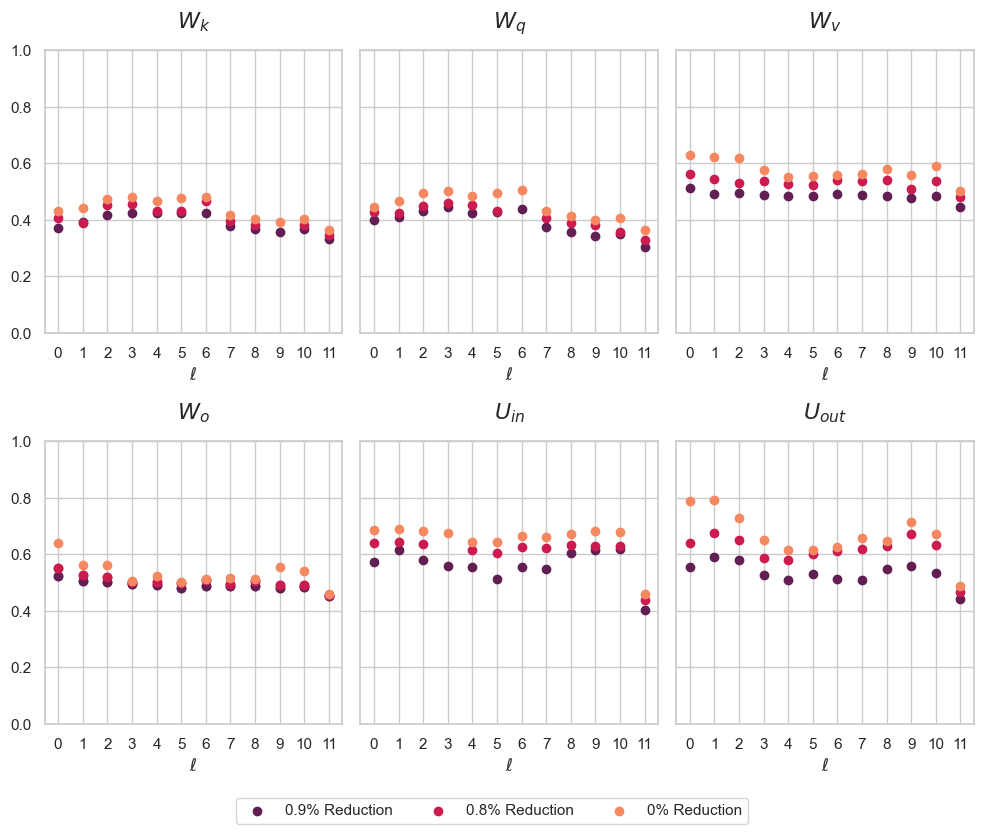

In [308]:
import ast

sns.set(style="whitegrid")
sns.set_palette("muted")

# Custom color palette for the plots
colors = sns.color_palette("rocket", 3)  # Using 3 shades of reddish-purple




blocks = {
    'attention.query_key_value.weight': 0,
    'attention.dense.weight': 1,
    'mlp.dense_h_to_4h.weight': 2,
    'mlp.dense_4h_to_h.weight': 3
}


block_labels = [f"$W_{{kqv}}$", f"$W_o$", f"$U_{{in}}$", f"$U_{{out}}$", ]


metric = 'corrected_final_top1_accuracy'

models = ["pythia160m", "pythia410m"]



for m in range(len(models)):
    df, df_none = collect_data(models[m])
    #df = df[df['rate'] == 0.9]
    blocks_df = df['lname'].unique()
    
    fig, axes = plt.subplots(1, len(blocks_df), figsize=(int(3.5 * len(blocks_df)), 5), sharey=True)

    handles, labels = [], []
    
    for block in blocks_df:

        b = blocks[block]

        ax = axes[b]

        for rate, color in zip([0.9, 0.8, 0], colors):
            
            if rate == 0 and 'edited' not in metric:
                data = df_none[df_none['lname'] == block]
                out = data[metric]
                ax.scatter(data['lnum'], out, label=f'{rate}% Reduction', color=color)
            elif "edited" in metric and rate == 0:
                ax.plot(data['lnum'], data["original_top1_accuracy"], label=f'{rate}% Reduction', color=colors[2], linestyle = "--", linewidth = 2)
            else:
                data = df[(df['lname'] == block) & (df['rate'] == rate)]
                ax.scatter(data['lnum'], data[metric], label=f'{rate}% Reduction', color=color)

        # Collect handles and labels
        handle, label = ax.get_legend_handles_labels()
        handles.extend(handle)
        labels.extend(label)


        if '410' in models[m]:
            ax.set_xticks(range(0, 24, 2))
            ax.set_xticklabels(range(0, 24, 2))
        else:
            ax.set_xticks(range(12))
            ax.set_xticklabels(range(12))

            
        ax.set_title(f"{block_labels[b]}", fontsize=16, y=1.05)
        #ax.set_title(block_labels[b1])
        ax.set_xlabel(f'$\\ell$')
        """if 'final' in metric:
            ax.set_ylim(0, 1)
        else:
            ax.set_ylim(0, 0.2)"""
        
        ax.set_ylim(0, 1)

        if b == 0:
            if metric == "final_top1_accuracy":
                ax.set_ylabel('Final Top-1 Accuracy')
            elif metric == "edited_top1_accuracy":
                ax.set_ylabel('Edited Model Top-1 Accuracy')
            elif metric == "edited_loss":
                ax.set_ylabel('Edited Model Loss')
            elif metric == "final_loss":
                ax.set_ylabel('Final Model Loss')
            if metric == "final_top10_accuracy":
                ax.set_ylabel('Final Top-10 Accuracy')
            elif metric == "edited_top10_accuracy":
                ax.set_ylabel('Edited Model Top-10 Accuracy')

    fig.legend(handles=handles[:3], labels=labels[:3], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))




    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(f'outputs/plots/performance_{models[m]}_{metric}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.5)
    plt.show()




blocks = {
    'attention.self.key': 0,
    'attention.self.query': 1,
    'attention.self.value': 2,
    'attention.output.dense': 3,
    'intermediate.dense.weight': 4,
    'output.dense.weight': 5
}

block_labels = [f"$W_k$", f"$W_q$", f"$W_v$", f"$W_o$", f"$U_{{in}}$", f"$U_{{out}}$", f"$W_{{kqv}}$", f"$W_o$", f"$U_{{in}}$", f"$U_{{out}}$"]

models = ["roberta_base"]

for m in range(len(models)):
    df, df_none = collect_data(models[m])
    #df = df[df['rate'] == 0.9]
    blocks_df = df['lname'].unique()
    
    fig, axes = plt.subplots(2, 3, figsize=(int(3.5 * 3), 8), sharey=True)

    handles, labels = [], []

    for block in blocks_df:

        b = blocks[block]

        a2 = b % 3
        a1 = b // 3

        ax = axes[a1, a2]

        for rate, color in zip([0.9, 0.8, 0], colors):
            if rate == 0 and 'edited' not in metric:
                data = df_none[df_none['lname'] == block]
                if b < 2:
                    data[metric] = data[metric] + 0.04
                out = data[metric]
                ax.scatter(data['lnum'], out, label=f'{rate}% Reduction', color=color)
            elif "edited" in metric and rate == 0:
                ax.plot(data['lnum'], data["original_top1_accuracy"], label=f'{rate}% Reduction', color=colors[2], linestyle = "--", linewidth = 2)
            else:
                data = df[(df['lname'] == block) & (df['rate'] == rate)]
                ax.scatter(data['lnum'], data[metric], label=f'{rate}% Reduction', color=color)

        # Collect handles and labels
        handle, label = ax.get_legend_handles_labels()
        handles.extend(handle)
        labels.extend(label)


        if '410' in models[m]:
            ax.set_xticks(range(0, 24, 2))
            ax.set_xticklabels(range(0, 24, 2))
        else:
            ax.set_xticks(range(12))
            ax.set_xticklabels(range(12))

        ax.set_title(f"{block_labels[b]}", fontsize=16, y= 1.05)
        ax.set_xlabel(f'$\\ell$')


        """if 'final' in metric:
            ax.set_ylim(0, 1)
        else:
            ax.set_ylim(0, 0.2)
        """

        ax.set_ylim(0, 1)
        


        if b == 0 or b == 3:
            if metric == "final_top1_accuracy":
                ax.set_ylabel('Final Top-1 Accuracy')
            elif metric == "edited_top1_accuracy":
                ax.set_ylabel('Edited Model Top-1 Accuracy')
            elif metric == "edited_loss":
                ax.set_ylabel('Edited Model Loss')
            elif metric == "final_loss":
                ax.set_ylabel('Final Model Loss')
            if metric == "final_top10_accuracy":
                ax.set_ylabel('Final Top-10 Accuracy')
            elif metric == "edited_top10_accuracy":
                ax.set_ylabel('Edited Model Top-10 Accuracy')

    #handles = list(set(handles))
    #labels = list(set(labels))
    fig.legend(handles=handles[:3], labels=labels[:3], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))




    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(f'outputs/plots/performance_{models[m]}_{metric}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.5)
    plt.show()




C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2913213394.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['change'] = subset['diff_edit_common_nouns'] - subset['diff_edit_proper_nouns']


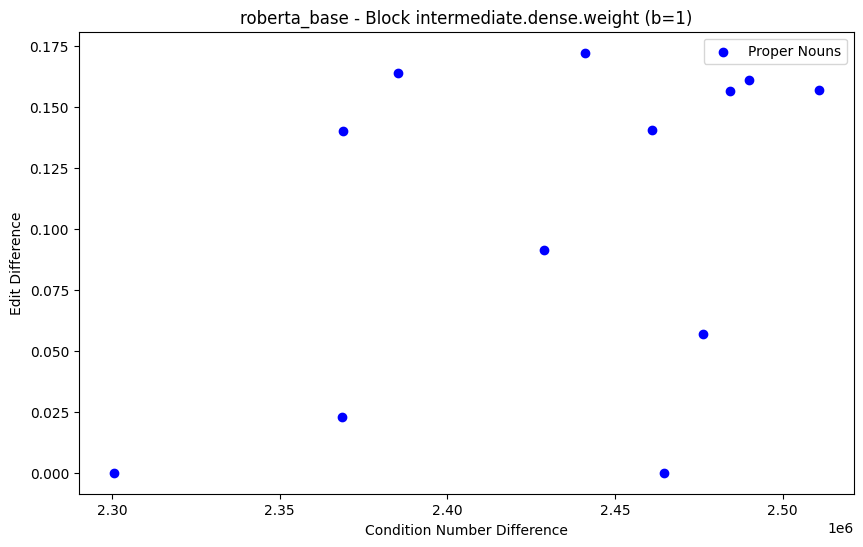

model: roberta_base
block: 1
     diff_condition_number  diff_edit_proper_nouns  diff_edit_common_nouns
78              2300550.00                 -9590.0                  2608.0
79              2368558.75                  -449.0                   146.0
77              2368923.75                  -490.0                   152.0
152             2385276.25                    95.0                   -31.0
159             2428649.00                    82.0                    26.0
153             2440935.00                  -204.0                   125.0
160             2460981.50                    94.0                   -10.0
158             2464592.25                  2091.0                  -456.0
80              2476211.75                  -836.0                   330.0
162             2484155.25                 -1094.0                   500.0
161             2489951.50                   412.0                   -96.0
154             2510675.25                  -205.0                    5

C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2913213394.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['change'] = subset['diff_edit_common_nouns'] - subset['diff_edit_proper_nouns']


<Figure size 640x480 with 0 Axes>

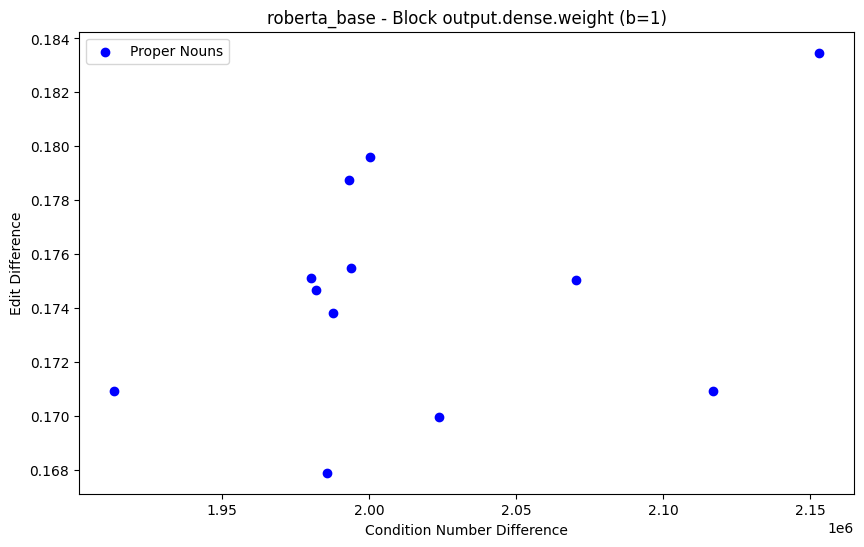

model: roberta_base
block: 2
     diff_condition_number  diff_edit_proper_nouns  diff_edit_common_nouns
104            1913364.000                   -99.0                    34.0
151            1980408.000                  -181.0                    67.0
164            1981948.250                  -619.0                   156.0
150            1985810.250                    -7.0                    39.0
111            1987784.000                   -26.0                    11.0
143            1993015.750                  -136.0                    80.0
163            1993805.500                  -110.0                    59.0
147            2000435.875                  -195.0                    83.0
125            2023819.500                   -82.0                    59.0
137            2070378.000                  -134.0                    51.0
130            2116888.000                  -160.0                    45.0
118            2152892.750                  -207.0                    9

C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2913213394.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['change'] = subset['diff_edit_common_nouns'] - subset['diff_edit_proper_nouns']


<Figure size 640x480 with 0 Axes>

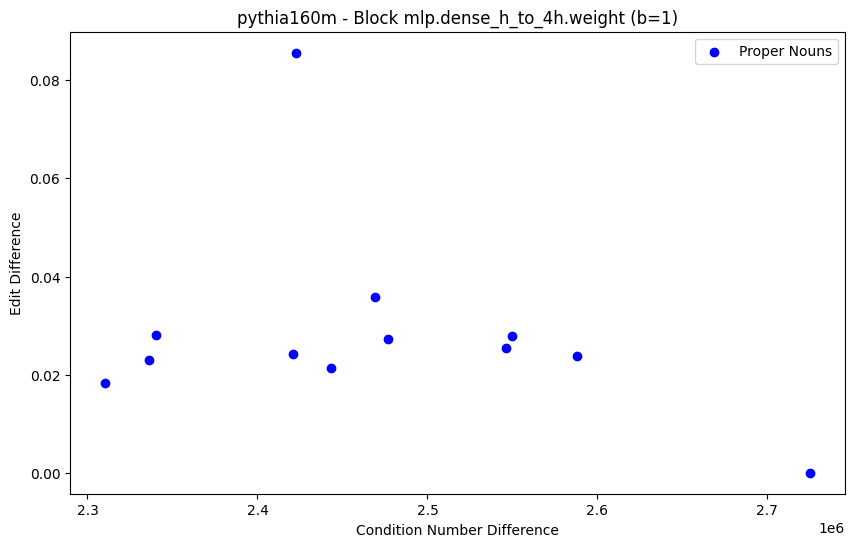

model: pythia160m
block: 1
    diff_condition_number  diff_edit_proper_nouns  diff_edit_common_nouns
82             2310460.50                   170.0                   -45.0
74             2336157.25                    -8.0                   -26.0
76             2340086.50                   115.0                   -29.0
78             2420703.75                   -49.0                    18.0
83             2422730.50                  -983.0                   193.0
80             2443122.50                   249.0                   -28.0
77             2469238.00                   -26.0                    -3.0
81             2476528.00                   -66.0                    18.0
79             2545959.75                 -1123.0                   500.0
73             2550020.50                  -170.0                    29.0
75             2587826.50                    40.0                    -4.0
72             2724925.25                 -3067.0                   383.0


C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2913213394.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['change'] = subset['diff_edit_common_nouns'] - subset['diff_edit_proper_nouns']


<Figure size 640x480 with 0 Axes>

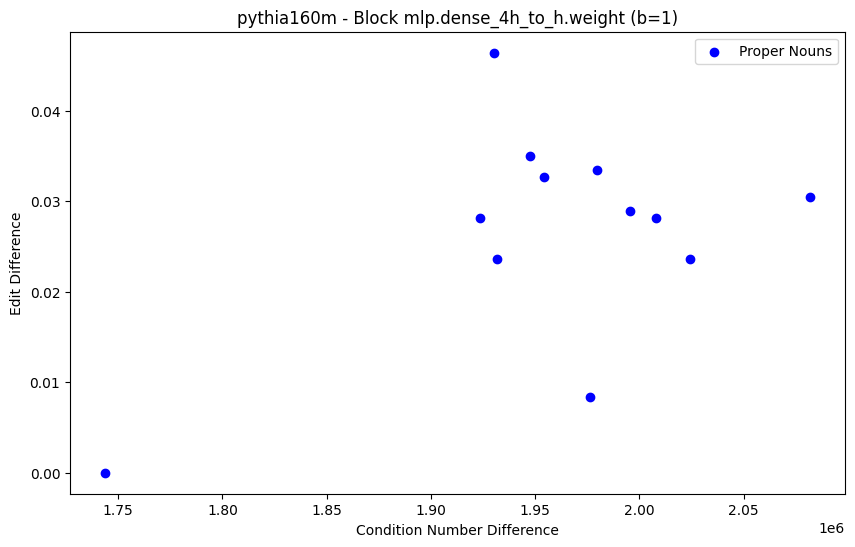

model: pythia160m
block: 2
    diff_condition_number  diff_edit_proper_nouns  diff_edit_common_nouns
84            1743764.750                  -226.0                    15.0
92            1923663.125                    18.0                    -5.0
87            1930010.750                    -9.0                    -3.0
93            1931708.875                    19.0                    -7.0
86            1947466.625                     2.0                     0.0
90            1954044.125                    30.0                    -4.0
94            1976298.250                    40.0                    -4.0
95            1979478.250                   -39.0                    -3.0
91            1995344.375                   -32.0                     2.0
89            2007903.000                     6.0                     2.0
88            2024110.625                    27.0                    -4.0
85            2081725.375                     0.0                    10.0


C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2913213394.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['change'] = subset['diff_edit_common_nouns'] - subset['diff_edit_proper_nouns']


<Figure size 640x480 with 0 Axes>

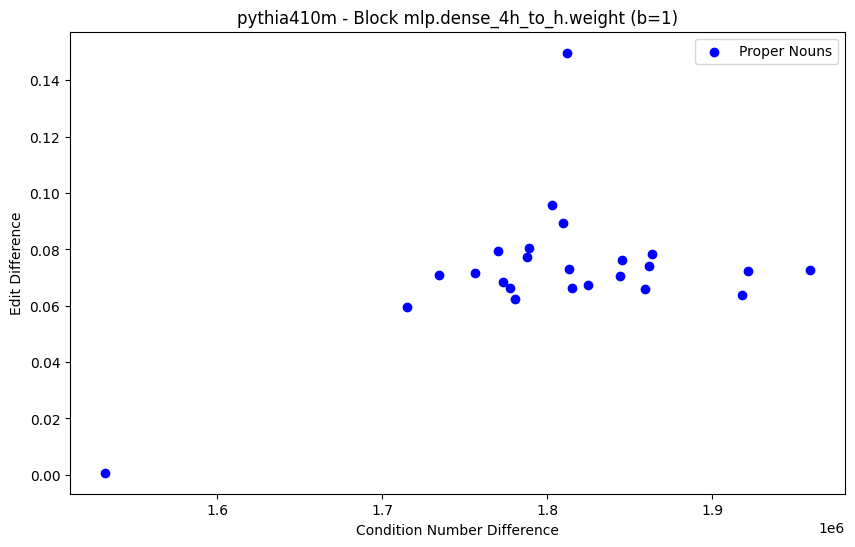

model: pythia410m
block: 2
    diff_condition_number  diff_edit_proper_nouns  diff_edit_common_nouns
0             1532285.875                 -5298.0                   858.0
54            1715032.250                   129.0                   -48.0
12            1734588.000                    55.0                    26.0
3             1756126.000                    72.0                    -4.0
70            1769874.625                    58.0                   -14.0
43            1773278.000                   -49.0                   -10.0
6             1777374.375                    -9.0                    21.0
48            1780449.875                    82.0                   -23.0
31            1787640.375                   141.0                   -40.0
55            1789084.750                   -81.0                    15.0
71            1802970.500                  -106.0                    22.0
73            1809651.250                   -38.0                   -15.0
75         

C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2913213394.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['change'] = subset['diff_edit_common_nouns'] - subset['diff_edit_proper_nouns']


<Figure size 640x480 with 0 Axes>

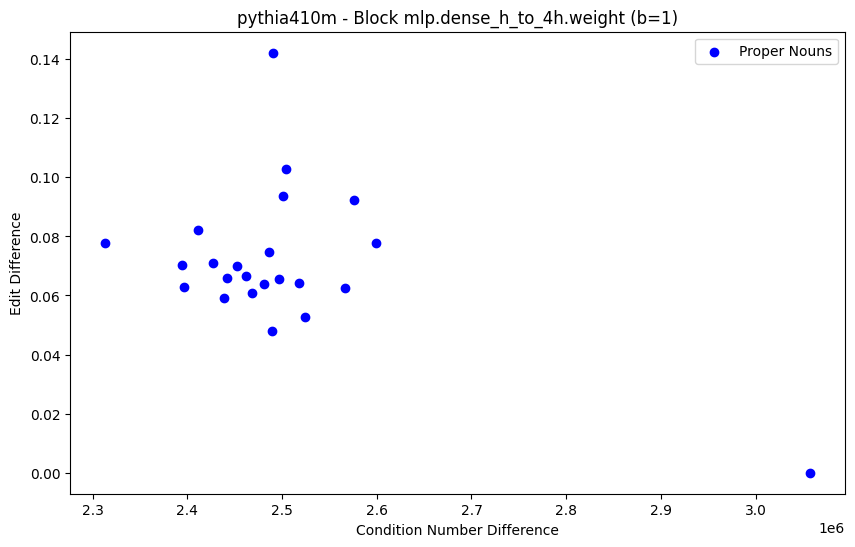

model: pythia410m
block: 1
     diff_condition_number  diff_edit_proper_nouns  diff_edit_common_nouns
113             2313460.75                    38.0                    -4.0
143             2394007.50                    70.0                   -20.0
103             2396924.75                   132.0                   -28.0
119             2411765.75                    50.0                     2.0
126             2427444.50                  -316.0                   133.0
116             2438628.50                   220.0                   -48.0
92              2442429.25                    -1.0                    25.0
140             2452633.00                    60.0                   -27.0
124             2462046.75                  -103.0                     7.0
97              2468763.50                     2.0                    17.0
107             2480847.00                  -136.0                    90.0
110             2486529.00                   -60.0                    15.

<Figure size 640x480 with 0 Axes>

In [293]:
import matplotlib.pyplot as plt

# Assuming other parts of your code, such as collect_data, are defined elsewhere

for m in range(len(models)):
    df, df_none = collect_data(models[m])
    df = df[df['rate'] == 0.9]
    blocks_df = df['lname'].unique()


    for block in blocks_df:
        try:
            b = blocks[block]
        except: 
            continue

        if b == 1 or b == 2:  # Only consider block b = 1
            subset = df[df['lname'] == block]
            
            # Plotting diff_edit_proper_nouns against diff_condition_number

            subset['change'] = subset['diff_edit_common_nouns'] - subset['diff_edit_proper_nouns']

            subset = subset.sort_values(by='diff_condition_number')

            plt.figure(figsize=(10, 6))
            #plt.scatter(subset['diff_condition_number'], subset['change'], label='Proper Nouns', color='blue')
            #plt.scatter(subset['diff_condition_number'], subset['diff_edit_common_nouns'], label='Common Nouns', color='green')
            plt.scatter(subset['diff_condition_number'], subset['edited_top1_accuracy'], label='Proper Nouns', color='blue')
            
            # Set titles and labels
            plt.title(f'{models[m]} - Block {block} (b=1)')
            plt.xlabel('Condition Number Difference')
            plt.ylabel('Edit Difference')
            plt.legend()

            # Show the plot
            plt.show()
            
            # Optionally, you can save the plot
            plt.savefig(f'outputs/plots/{models[m]}_block_{block}_diff_plot.pdf', format='pdf')

            # Print the data as before
            print(f"model: {models[m]}")
            print(f"block: {b}")
            print(subset[['diff_condition_number', 'diff_edit_proper_nouns', 'diff_edit_common_nouns']])


In [299]:
import pickle
from nltk.corpus import stopwords
from nltk import pos_tag


def classify_words(words):
    pos_tags = pos_tag(words)
    function_words = set(stopwords.words('english'))
    
    word_frequencies = {
        'common_nouns': 0,
        'proper_nouns': 0,
        'verbs': 0,
        'modal_verbs': 0,
        'adjectives': 0,
        'adverbs': 0,
        'determiners': 0,
        'conjunctions': 0,
        'prepositions': 0,
        'pronouns': 0,
        'interjections': 0,
        'numerals': 0,
        'function_words': 0
    }
    
    for word, tag in pos_tags:
        if word.lower() in function_words:
            word_frequencies['function_words'] += 1
        elif tag.startswith('NNP'):
            word_frequencies['proper_nouns'] += 1
        elif tag.startswith('NN'):
            word_frequencies['common_nouns'] += 1
        elif tag.startswith('VB'):
            if tag == 'MD':
                word_frequencies['modal_verbs'] += 1
            else:
                word_frequencies['verbs'] += 1
        elif tag.startswith('JJ'):
            word_frequencies['adjectives'] += 1
        elif tag.startswith('RB'):
            word_frequencies['adverbs'] += 1
        elif tag in ('DT', 'PDT', 'WDT'):
            word_frequencies['determiners'] += 1
        elif tag in ('CC', 'IN'):
            word_frequencies['conjunctions'] += 1
        elif tag in ('IN', 'TO'):
            word_frequencies['prepositions'] += 1
        elif tag in ('PRP', 'PRP$', 'WP', 'WP$'):
            word_frequencies['pronouns'] += 1
        elif tag == 'UH':
            word_frequencies['interjections'] += 1
        elif tag == 'CD':
            word_frequencies['numerals'] += 1
    
    return word_frequencies


def get_dataset(model_type):

    with open("data/counterfact", "rb") as f:
        data = pickle.load(f)


    num_dp = len(data)
    dataset = []

    X, y = [], []

    for i in range(num_dp):

        question = data[i]["question"]
        answer = data[i]["gold-answer"]
        assert answer.startswith(" "), f"Found answer that doesn't start with space ${answer}$"
        dataset.append((question, answer))

    
    for i in range(len(dataset)):
        question, answer = dataset[i]

        if model_type == "masked":
            if question.endswith(" "):
                question = f"{question}<mask>."
            else:
                question = f"{question} <mask>."

        X.append(question)
        y.append(answer)

    return X, y

X, y = get_dataset("causal")

cat = classify_words(y)
print(cat)



{'common_nouns': 2943, 'proper_nouns': 54421, 'verbs': 896, 'modal_verbs': 0, 'adjectives': 7293, 'adverbs': 138, 'determiners': 1, 'conjunctions': 15, 'prepositions': 0, 'pronouns': 27, 'interjections': 0, 'numerals': 1, 'function_words': 0}


In [324]:
table_text= ""

models = ["roberta_base", "pythia160m", "pythia410m"]

labs = ["RoBERTa", "Pythia-160M", "Pythia-410M"]

blocks_d = {
    'attention.dense.weight': 3,
    'mlp.dense_h_to_4h.weight': 4,
    'mlp.dense_4h_to_h.weight': 5, 
    'attention.output.dense': 3,
    'intermediate.dense.weight': 4,
    'output.dense.weight': 5,
    'attention.self.key': 1,
    'attention.self.query': 0,
    'attention.self.value': 2,
    'attention.query_key_value.weight': 6
}

lab = [f'$W_{{q}}$', f'$W_{{k}}$', f'$W_{{v}}$', f'$W_{{o}}$', 
       f'$U_{{in}}$', f'$U_{{out}}$', f'$W_{{qkv}}$']


for m in range(len(models)):
    df, df_none = collect_data(models[m])

    blocks = df['lname'].unique()

    for block in blocks:

        b = blocks_d[block]

        table_text += f"& {lab[b]}"

        for rate in [0, 0.8]:
            if rate == 0:
                data = df_none[df_none['lname'] == block]
            else:
                table_text += f" & "
                data = df[(df['lname'] == block) & (df['rate'] == rate)]

            
            mean_acc = np.mean(data["corrected_final_top1_accuracy"])
            best_acc  = np.max(data["corrected_final_top1_accuracy"])
            worst_acc  = np.min(data["corrected_final_top1_accuracy"])

            mean_per = np.mean(data["correct_final_perplexity"])
            best_per = np.min(data["correct_final_perplexity"])
            worst_per  = np.max(data["correct_final_perplexity"])

            table_text += f" & {rate} & {mean_acc:.4f} & {best_acc:.4f} & {mean_per:.4f} & {best_per:.4f} \\\\ \n"

            if rate == 0.8:
                table_text += "\\hline \n"

print(table_text)


& $W_{o}$ & 0 & 0.5322 & 0.6399 & 1.4428 & 1.4175 \\ 
 &  & 0.8 & 0.5032 & 0.5508 & 1.4411 & 1.4249 \\ 
\hline 
& $W_{k}$ & 0 & 0.3957 & 0.4424 & 1.6912 & 1.5865 \\ 
 &  & 0.8 & 0.4128 & 0.4653 & 1.6700 & 1.5756 \\ 
\hline 
& $W_{q}$ & 0 & 0.4107 & 0.4644 & 1.6856 & 1.5784 \\ 
 &  & 0.8 & 0.4103 & 0.4612 & 1.6824 & 1.5614 \\ 
\hline 
& $W_{v}$ & 0 & 0.5759 & 0.6284 & 1.4504 & 1.4363 \\ 
 &  & 0.8 & 0.5313 & 0.5630 & 1.4478 & 1.4369 \\ 
\hline 
& $U_{in}$ & 0 & 0.6533 & 0.6893 & 1.3396 & 1.2580 \\ 
 &  & 0.8 & 0.6105 & 0.6431 & 1.3399 & 1.2526 \\ 
\hline 
& $U_{out}$ & 0 & 0.6658 & 0.7931 & 1.4092 & 1.3484 \\ 
 &  & 0.8 & 0.6135 & 0.6760 & 1.4081 & 1.3721 \\ 
\hline 
& $W_{o}$ & 0 & 0.4475 & 0.5049 & 1.4349 & 1.3870 \\ 
 &  & 0.8 & 0.4358 & 0.5021 & 1.3936 & 1.3724 \\ 
\hline 
& $W_{qkv}$ & 0 & 0.4952 & 0.5620 & 1.3816 & 1.3350 \\ 
 &  & 0.8 & 0.4899 & 0.5700 & 1.3555 & 1.3089 \\ 
\hline 
& $U_{out}$ & 0 & 0.5770 & 0.7340 & 1.3422 & 1.1986 \\ 
 &  & 0.8 & 0.5231 & 0.6384 & 1.3747 & 1.35

In [312]:
models = ["roberta_base", "pythia160m", "pythia410m"]



dependent_vars = [
    'corrected_final_top1_accuracy',
    'edited_top1_accuracy',
    'final_change_from_reduction',
    'diff_edit_common_nouns',
    'diff_edit_proper_nouns',
    'diff_edit_verbs',
    #'diff_edit_modal_verbs',
    'diff_edit_adjectives',
    'diff_edit_adverbs',
    #'diff_edit_determiners',
    'diff_edit_conjunctions',
    #'diff_edit_prepositions',
    'diff_edit_pronouns',
    #'diff_edit_interjections',
    #'diff_edit_numerals',
    'diff_edit_function_words',
    'diff_final_common_nouns',
    'diff_final_proper_nouns',
    'diff_final_verbs',
    #'diff_final_modal_verbs',
    'diff_final_adjectives',
    'diff_final_adverbs',
    #'diff_final_determiners',
    'diff_final_conjunctions',
    #'diff_final_prepositions',
    'diff_final_pronouns',
    #'diff_final_interjections',
    #'diff_final_numerals',
    #'diff_final_function_words'
]



indep_1 = ['frobenius_norm', 'spectral_norm', 'nuclear_norm', 'condition_number']

indep_2 = ['original_', 'edited_', 'diff_']


blocks = {
    'attention.dense.weight': 0,
    'mlp.dense_h_to_4h.weight': 1,
    'mlp.dense_4h_to_h.weight': 2, 
    'attention.output.dense': 0,
    'intermediate.dense.weight': 1,
    'output.dense.weight': 2
}

#                   d                   i1 i2  m  b  corr and pval
results = np.zeros((len(dependent_vars), 4, 3, 3, 3, 2))


for m in range(len(models)):
    df, df_none = collect_data(models[m])
    df = df[df['rate']==0.9]
    for d in range(len(dependent_vars)):
        for i1 in range(len(indep_1)):
            for i2 in range(len(indep_2)):
                for b, n in blocks.items():
                    subset = df[df['lname'] == b]
                    ind = indep_2[i2]+indep_1[i1]
                    dep = dependent_vars[d]
                    valid_data = subset[[ind, dep]].dropna()
                    try:
                        corr, pval = pearsonr(valid_data[ind], valid_data[dep])
                        results[d, i1, i2, m, n, 0] = corr
                        results[d, i1, i2, m, n, 1] = pval
                    except:continue




roberta.encoder.layer.0.attention.self.key.weight
roberta.encoder.layer.1.attention.self.key.weight
roberta.encoder.layer.2.attention.self.key.weight
roberta.encoder.layer.3.attention.self.key.weight
roberta.encoder.layer.4.attention.self.key.weight
roberta.encoder.layer.5.attention.self.key.weight
roberta.encoder.layer.6.attention.self.key.weight
roberta.encoder.layer.7.attention.self.key.weight
roberta.encoder.layer.8.attention.self.key.weight
roberta.encoder.layer.9.attention.self.key.weight
roberta.encoder.layer.10.attention.self.key.weight
roberta.encoder.layer.11.attention.self.key.weight
roberta.encoder.layer.0.attention.self.query.weight
roberta.encoder.layer.1.attention.self.query.weight
roberta.encoder.layer.2.attention.self.query.weight
roberta.encoder.layer.3.attention.self.query.weight
roberta.encoder.layer.4.attention.self.query.weight
roberta.encoder.layer.5.attention.self.query.weight
roberta.encoder.layer.6.attention.self.query.weight
roberta.encoder.layer.7.attention.

C:\Users\will-\AppData\Local\Temp\ipykernel_5972\4002844383.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(valid_data[ind], valid_data[dep])
C:\Users\will-\AppData\Local\Temp\ipykernel_5972\4002844383.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(valid_data[ind], valid_data[dep])
C:\Users\will-\AppData\Local\Temp\ipykernel_5972\4002844383.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(valid_data[ind], valid_data[dep])
C:\Users\will-\AppData\Local\Temp\ipykernel_5972\4002844383.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(valid_data[ind], valid_data[dep])
C:\Users\will-\AppData\Local\Temp\ipykernel_5972\4002844383.py:69: ConstantInputWarning: An input array is constant; the cor

gpt_neox.layers.0.attention.dense.weight
gpt_neox.layers.0.attention.query_key_value.weight
gpt_neox.layers.0.mlp.dense_4h_to_h.weight
gpt_neox.layers.0.mlp.dense_h_to_4h.weight
gpt_neox.layers.1.attention.dense.weight
gpt_neox.layers.1.attention.query_key_value.weight
gpt_neox.layers.1.mlp.dense_4h_to_h.weight
gpt_neox.layers.1.mlp.dense_h_to_4h.weight
gpt_neox.layers.10.attention.dense.weight
gpt_neox.layers.10.attention.query_key_value.weight
gpt_neox.layers.10.mlp.dense_4h_to_h.weight
gpt_neox.layers.10.mlp.dense_h_to_4h.weight
gpt_neox.layers.11.attention.dense.weight
gpt_neox.layers.11.attention.query_key_value.weight
gpt_neox.layers.11.mlp.dense_4h_to_h.weight
gpt_neox.layers.11.mlp.dense_h_to_4h.weight
gpt_neox.layers.12.attention.dense.weight
gpt_neox.layers.12.attention.query_key_value.weight
gpt_neox.layers.12.mlp.dense_4h_to_h.weight
gpt_neox.layers.12.mlp.dense_h_to_4h.weight
gpt_neox.layers.13.attention.dense.weight
gpt_neox.layers.13.attention.query_key_value.weight
gpt_

In [313]:

def format_corr(corr, pval):
    if pval < 0.1:
        pval_formatted = f"{pval:.3e}".split("e")
        pval_formatted = f"{pval_formatted[0]} \\times 10^{{{int(pval_formatted[1])}}}"
        return f" & {corr:.4f} & \\colorbox{{mycolor}}{{${pval_formatted}$}} "
    else:
        pval_formatted = f"{pval:.3e}".split("e")
        try:
            pval_formatted = f"{pval_formatted[0]} \\times 10^{{{int(pval_formatted[1])}}}"
        except:
            pval_formatted = pval
        return f" & {corr:.4f} & ${pval_formatted}$ "

In [314]:
table_code = ""

for d in range(len(dependent_vars)):
    if "edit" in dependent_vars[d]:
        text1 = f"\\textbf{{without}} subsequent fine-tuning"
    else:
        text1 = f"with subsequent fine-tuning"
    if d > 2:
        word = dependent_vars[d].split("_") 
        if len(word) > 3:
            # Join all parts from the second element onwards
            word = ' '.join(word[2:])
        else:
            word = word[-1]
        text2 = f"change in frequency of \\textit{{{word}}} token prediction (induced by the low rank intervention; {text1})"
    elif "change" in dependent_vars[d]:
        text2 = f"the change in top-1 accuracy of the model (due to the low rank intervention; {text1})"
    else:
        text2 = f"the top-1 accuracy of the model"

    caption = f"Pearson correlation coefficients and p-values for the relationship between the {text2} and weight matrix properties. With a reduction rate of 0.9."

    table_code += f"\\begin{{table}}\n\\begin{{footnotesize}}\n\\begin{{center}}\n"
    table_code += f"\\renewcommand{{\\arraystretch}}{{1.25}}\n"
    table_code += f"\\caption{{{caption}}}\n"
    table_code += f"\\label{{table:{dependent_vars[d]}_{indep_1[i1]}}} \\\\ \n"
    table_code += f"\\vspace{{0.4cm}}\n"
    table_code += f"\\begin{{tabular}}{{|p{{1cm}} p{{2.3cm}} || m{{1.5cm}} | m{{1.5cm}} | m{{1.5cm}}  |m{{1.5cm}}  m{{1.5cm}} m{{1.5cm}} }}\n"
    
    for i1 in range(len(indep_1)):

        table_code += f"\\hline\n"

        if indep_1[i1] == "condition_number":
            table_code += f"& & \\multicolumn{{2}}{{m|}}{{$\\kappa ( \\mathcal{{W}} ) $}} & \\multicolumn{{2}}{{m|}}{{$\\kappa ( \\hat{{\\mathcal{{W}}}} ) $}} & \\multicolumn{{2}}{{m|}}{{$\\kappa ( \\mathcal{{W}} - \\hat{{\\mathcal{{W}}}} ) $}} \\\\ \n"
        else:
            if indep_1[i1] == "frobenius_norm":
                s = "F"
            if indep_1[i1] == "spectral_norm":
                s = "2"
            if indep_1[i1] == "nuclear_norm":
                s = "*"
            table_code += f"& & \\multicolumn{{2}}{{m|}}{{$\\lVert \\mathcal{{W}} \\rVert_{{{s}}}$}} & \\multicolumn{{2}}{{m|}}{{$\\lVert \\hat{{\\mathcal{{W}}}} \\rVert_{{{s}}}$}} & \\multicolumn{{2}}{{m|}}{{$\\lVert \\mathcal{{W}} - \\hat{{\\mathcal{{W}}}} \\rVert_{{{s}}}$}} \\\\ \n"


        table_code += f"$\\mathcal{{W}}$ & Model & $r$ & $p$ & $r$ & $p$ & $r$ & $p$ \\\\ \n"
        table_code += f"\\hline\n\\hline\n"


        for b in [0, 1, 2]:
            if b == 0:
                table_code += f"$W_{{o}}$ "
            elif b == 1:
                table_code += f"$U_{{in}}$ "
            elif b == 2:
                table_code += f"$U_{{out}}$ "
            for m in [0, 1, 2]:
                if m == 0:
                    table_code += f" & RoBERTa"
                elif m == 1:
                    table_code += f" & Pythia-160M"
                elif m == 2:
                    table_code += f" & Pythia-410M" 

                for i2 in [0, 1, 2]:
                    if i2 == 1 and i1 == 1:
                        table_code += f" & - & - "
                    else:
                        table_code += format_corr(results[d, i1, i2, m, b, 0], results[d, i1, i2, m, b, 1])
                table_code += f"\\\\ \n"
            table_code += f"\\hline \n"

        #table_code += f"\\vspace{{0.2cm}}\n\\hline \n"

    table_code += "\\end{tabular}\n\\end{center}\n\\end{footnotesize}\n\\end{table}\n\n\n"

print(table_code)


\begin{table}
\begin{footnotesize}
\begin{center}
\renewcommand{\arraystretch}{1.25}
\caption{Pearson correlation coefficients and p-values for the relationship between the the top-1 accuracy of the model and weight matrix properties. With a reduction rate of 0.9.}
\label{table:corrected_final_top1_accuracy_condition_number} \\ 
\vspace{0.4cm}
\begin{tabular}{|p{1cm} p{2.3cm} || m{1.5cm} | m{1.5cm} | m{1.5cm}  |m{1.5cm}  m{1.5cm} m{1.5cm} }
\hline
& & \multicolumn{2}{m|}{$\lVert \mathcal{W} \rVert_{F}$} & \multicolumn{2}{m|}{$\lVert \hat{\mathcal{W}} \rVert_{F}$} & \multicolumn{2}{m|}{$\lVert \mathcal{W} - \hat{\mathcal{W}} \rVert_{F}$} \\ 
$\mathcal{W}$ & Model & $r$ & $p$ & $r$ & $p$ & $r$ & $p$ \\ 
\hline
\hline
$W_{o}$  & RoBERTa & 0.0390 & $8.563 \times 10^{-1}$  & 0.4347 & \colorbox{mycolor}{$3.378 \times 10^{-2}$}  & -0.5249 & \colorbox{mycolor}{$8.448 \times 10^{-3}$} \\ 
 & Pythia-160M & 0.5750 & \colorbox{mycolor}{$5.047 \times 10^{-2}$}  & 0.6621 & \colorbox{mycolor}{$1.900 

In [183]:
table_code = ""

for d in range(len(dependent_vars)):
    if "edit" in dependent_vars[d]:
        text1 = f"the models following intervention but \\textbf{{without}} subsequent fine-tuning"
    else:
        text1 = f"the models following intervention and subsequent fine-tuning"
    for i1 in range(len(indep_1)):
        if d > 2:
            word = dependent_vars[d].split("_") 
            if len(word) > 3:
                # Join all parts from the second element onwards
                word = ' '.join(word[2:])
            else:
                word = word[-1]
            text2 = f"change in frequency of {word} token prediction (induced by the low rank intervention)"
        elif "change" in dependent_vars[d]:
            text2 = f"the drop in top-1 accuracy of the model (due to the low rank intervention)"
        else:
            text2 = f"the top-1 accuracy of the model"

        caption = f"The Pearson correlation coefficients and p-values for the relationship between the {text2} and the {" ".join(indep_1[i1].split("_"))} of the weight matrices (across all layers of each given transformer block). This table displays the results for {text1}. The p-values that fall below the significance threshold of 0.1 are shaded in grey."

        table_code += f"\\begin{{table}}\n\\begin{{small}}\n\\begin{{center}}\n"
        table_code += f"\\renewcommand{{\\arraystretch}}{{1.5}}\n"
        table_code += f"\\caption{{{caption}}}\n"
        table_code += f"\\label{{table:{dependent_vars[d]}_{indep_1[i1]}}} \\\\ \n"
        table_code += f"\\vspace{{0.4cm}}\n"
        table_code += f"\\begin{{tabular}}{{|p{{1cm}} p{{2.3cm}} || m{{1.5cm}} | m{{1.5cm}} | m{{1.5cm}}  |m{{1.5cm}}  m{{1.5cm}} m{{1.5cm}} }}\n"
        table_code += f"\\hline\n"

        if indep_1[i1] == "condition_number":
            table_code += f"& & \\multicolumn{{2}}{{m|}}{{$\\kappa \\left( \\mathcal{{W}} \\right) $}} & \\multicolumn{{2}}{{m|}}{{$\\kappa \\left( \\hat{{\\mathcal{{W}}}} \\right) $}} & \\multicolumn{{2}}{{m|}}{{$\\kappa \\left( \\mathcal{{W}} - \\hat{{\\mathcal{{W}}}} \\right) $}} \\\\ \n"
        else:
            if indep_1[i1] == "frobenius_norm":
                s = "F"
            if indep_1[i1] == "spectral_norm":
                s = "2"
            if indep_1[i1] == "nuclear_norm":
                s = "*"
            table_code += f"& & \\multicolumn{{2}}{{m|}}{{$\\lVert \\mathcal{{W}} \\rVert_{{*}}$}} & \\multicolumn{{2}}{{m|}}{{$\\lVert \\hat{{\\mathcal{{W}}}} \\rVert_{{*}}$}} & \\multicolumn{{2}}{{m|}}{{$\\lVert \\mathcal{{W}} - \\hat{{\\mathcal{{W}}}} \\rVert_{{*}}$}} \\\\ \n"


        table_code += f"$\\mathcal{{W}}$ & Model & $r$ & $p$ & $r$ & $p$ & $r$ & $p$ \\\\ \n"
        table_code += f"\\hline\n\\hline\n"


        for b in [0, 1, 2]:
            if b == 0:
                table_code += f"$W_{{o}}$ "
            elif b == 1:
                table_code += f"$U_{{in}}$ "
            elif b == 2:
                table_code += f"$U_{{out}}$ "
            for m in [0, 1, 2]:
                if m == 0:
                    table_code += f" & RoBERTa"
                elif m == 1:
                    table_code += f" & Pythia-160M"
                elif m == 2:
                    table_code += f" & Pythia-410M" 

                for i2 in [0, 1, 2]:
                    table_code += format_corr(results[d, i1, i2, m, b, 0], results[d, i1, i2, m, b, 1])
                table_code += f"\\\\ \n"
            table_code += f"\\hline \n"

        table_code += 

    table_code += "\\end{tabular}\n\\end{center}\n\\end{small}\n\\end{table}\n\n\n"

print(table_code)



\begin{table}
\begin{small}
\begin{center}
\renewcommand{\arraystretch}{1.5}
\caption{The Pearson correlation coefficients and p-values for the relationship between the the top-1 accuracy of the model and the frobenius norm of the weight matrices (across all layers of each given transformer block). This table displays the results for the models following intervention and subsequent fine-tuning. The p-values that fall below the significance threshold of 0.1 are shaded in grey.}
\label{table:final_top1_accuracy_frobenius_norm} \\ 
\vspace{0.4cm}
\begin{tabular}{|p{1cm} p{2.3cm} || m{1.5cm} | m{1.5cm} | m{1.5cm}  |m{1.5cm}  m{1.5cm} m{1.5cm} }
\hline
& & \multicolumn{2}{m|}{$\lVert \mathcal{W} \rVert_{*}$} & \multicolumn{2}{m|}{$\lVert \hat{\mathcal{W}} \rVert_{*}$} & \multicolumn{2}{m|}{$\lVert \mathcal{W} - \hat{\mathcal{W}} \rVert_{*}$} \\ 
$\mathcal{W}$ & Model & $r$ & $p$ & $r$ & $p$ & $r$ & $p$ \\ 
\hline
\hline
$W_{o}$  & RoBERTa & 0.0390 & 8.563e-01  & 0.4347 & \colorbox{mycolor}{

In [170]:
models = ["roberta_base", "pythia160m", "pythia410m"]

dependent_vars = [
    #'final_top1_accuracy',
    #'final_change_from_reduction',
    'diff_edit_common_nouns',
    'diff_edit_proper_nouns',
    'diff_edit_verbs',
    #'diff_edit_modal_verbs',
    'diff_edit_adjectives',
    'diff_edit_adverbs',
    'diff_edit_determiners',
    'diff_edit_conjunctions',
    #'diff_edit_prepositions',
    'diff_edit_pronouns',
    #'diff_edit_interjections',
    #'diff_edit_numerals',
    'diff_edit_function_words',
    'diff_final_common_nouns',
    'diff_final_proper_nouns',
    'diff_final_verbs',
    #'diff_final_modal_verbs',
    'diff_final_adjectives',
    'diff_final_adverbs',
    'diff_final_determiners',
    'diff_final_conjunctions',
    #'diff_final_prepositions',
    'diff_final_pronouns',
    #'diff_final_interjections',
    #'diff_final_numerals',
    'diff_final_function_words'
]


independent_vars = [
    'lnum',
    #'relative_error_x', 
    'original_frobenius_norm',
    'original_spectral_norm', 
    'original_nuclear_norm', 
    'original_condition_number', 
    #'original_shannon_entropy',
    'diff_frobenius_norm', 
    'diff_spectral_norm', 
    'diff_nuclear_norm', 
    'diff_condition_number', 
    #'diff_shannon_entropy', 
    #'energy_retained',
    'edited_frobenius_norm',
    'edited_spectral_norm',
    'edited_nuclear_norm',
    'edited_condition_number',
    #'edited_cut_off_sv',
    #'edited_shannon_entropy'
]

indep_1 = ['frobenius_norm', 'spectral_norm', 'nuclear_norm', 'condition_number']

indep_2 = ['original_', 'edited_', 'diff_']


blocks = {
    'attention.dense.weight': 0,
    'mlp.dense_h_to_4h.weight': 1,
    'mlp.dense_4h_to_h.weight': 2, 
    'attention.output.dense': 0,
    'intermediate.dense.weight': 1,
    'output.dense.weight': 2
}

#                   d                   i1 i2  m  b  corr and pval
results = np.zeros((len(dependent_vars), 4, 3, 3, 3, 2))


In [172]:
for model in models:
    df, df_none = collect_data(model)
    #df_analysis = analyse_metrics(model, df, dependent_vars, independent_vars)
    #plot_metrics(df, model, dependent_vars, independent_vars, sorted_blocks)

    df = df[df['rate'] == 0.8]
    grouped = df.groupby(['lname'])

    for block, group in grouped:

        if block[0] in sorted_blocks:

            #print(f"     {block}")
            
            for dep_var in dependent_vars:
                for indep_var in independent_vars:

                    valid_data = group[[indep_var, dep_var]].dropna()
                    try: 
                        pearson_corr, pearson_pval = pearsonr(valid_data[indep_var], valid_data[dep_var])

                        #if pearson_pval < 0.09:
                        print(f"{model},{dep_var},{indep_var},{pearson_pval},{pearson_corr}")
                    except:
                        #print(f"ERROR:     {dep_var}   {indep_var}")
                        x=1





            



#analysis_tables_corr = generate_analysis_tables(models, dependent_vars, independent_vars, "corr")
#analysis_tables_pval = generate_analysis_tables(models, dependent_vars, independent_vars, "pval")
#
#for dep_var, table in analysis_tables_corr.items():
#    table.to_csv(f"{dep_var}_analysis_table_corr.csv", index=True)
#for dep_var, table in analysis_tables_pval.items():
#    table.to_csv(f"outputs/results/analysis/grouped/{dep_var}_pval.csv", index=True)


#for model in models:
#    df, df_none = collect_data(model)
#    #df_analysis = analyse_metrics(model, df, dependent_vars, independent_vars)
#    plot_metrics(df, model, dependent_vars, independent_vars, sorted_blocks)

roberta_base,diff_edit_common_nouns,lnum,0.08841646433787961,0.3553035065917354
roberta_base,diff_edit_common_nouns,original_frobenius_norm,0.20962687078637804,0.26564218669770534
roberta_base,diff_edit_common_nouns,original_spectral_norm,0.3983053589044754,-0.1806317866315252
roberta_base,diff_edit_common_nouns,original_nuclear_norm,0.020710731382598352,0.46923628218802227
roberta_base,diff_edit_common_nouns,original_condition_number,0.02015459848332718,0.47106357454503034
roberta_base,diff_edit_common_nouns,diff_frobenius_norm,0.00791975129592598,0.5285905734993257
roberta_base,diff_edit_common_nouns,diff_spectral_norm,0.036117105662594795,0.4296953373509576
roberta_base,diff_edit_common_nouns,diff_nuclear_norm,0.05261784026062218,0.40025068767798405
roberta_base,diff_edit_common_nouns,diff_condition_number,0.038876074576714596,0.4241198552609062
roberta_base,diff_edit_common_nouns,edited_frobenius_norm,0.6653165898731355,0.09307766422434058
roberta_base,diff_edit_common_nouns,edited

C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2060796102.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval = pearsonr(valid_data[indep_var], valid_data[dep_var])
C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2060796102.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval = pearsonr(valid_data[indep_var], valid_data[dep_var])
C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2060796102.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval = pearsonr(valid_data[indep_var], valid_data[dep_var])
C:\Users\will-\AppData\Local\Temp\ipykernel_37932\2060796102.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval = pearsonr(valid_data[indep_var], valid_data[dep_var])
C:\Users\will-\A

roberta_base,diff_final_common_nouns,lnum,0.5535393462067719,-0.2009450899475988
roberta_base,diff_final_common_nouns,original_frobenius_norm,0.6748416622068127,0.14302138593414854
roberta_base,diff_final_common_nouns,original_spectral_norm,0.6835813041885932,0.13899420577993343
roberta_base,diff_final_common_nouns,original_nuclear_norm,0.6646377714250647,0.1477443905063589
roberta_base,diff_final_common_nouns,original_condition_number,0.036483260933033834,-0.6332388104210381
roberta_base,diff_final_common_nouns,diff_frobenius_norm,0.6782139158237938,0.14146553155233701
roberta_base,diff_final_common_nouns,diff_spectral_norm,0.7931847040746205,0.08966620829222752
roberta_base,diff_final_common_nouns,diff_nuclear_norm,0.6248958224561091,0.1663752331979801
roberta_base,diff_final_common_nouns,diff_condition_number,0.5977825305369892,-0.17932569837241089
roberta_base,diff_final_common_nouns,edited_frobenius_norm,0.6850223227257054,0.13833174759892808
roberta_base,diff_final_common_nouns,e

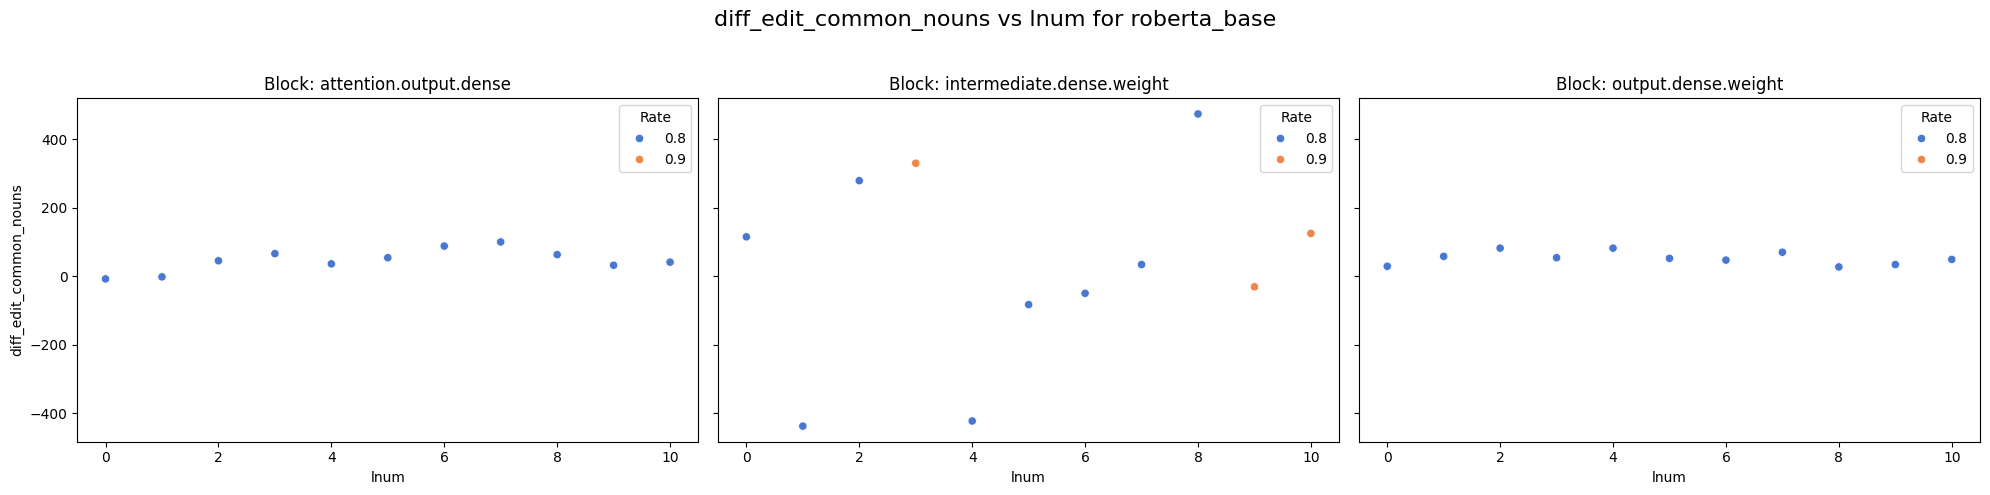

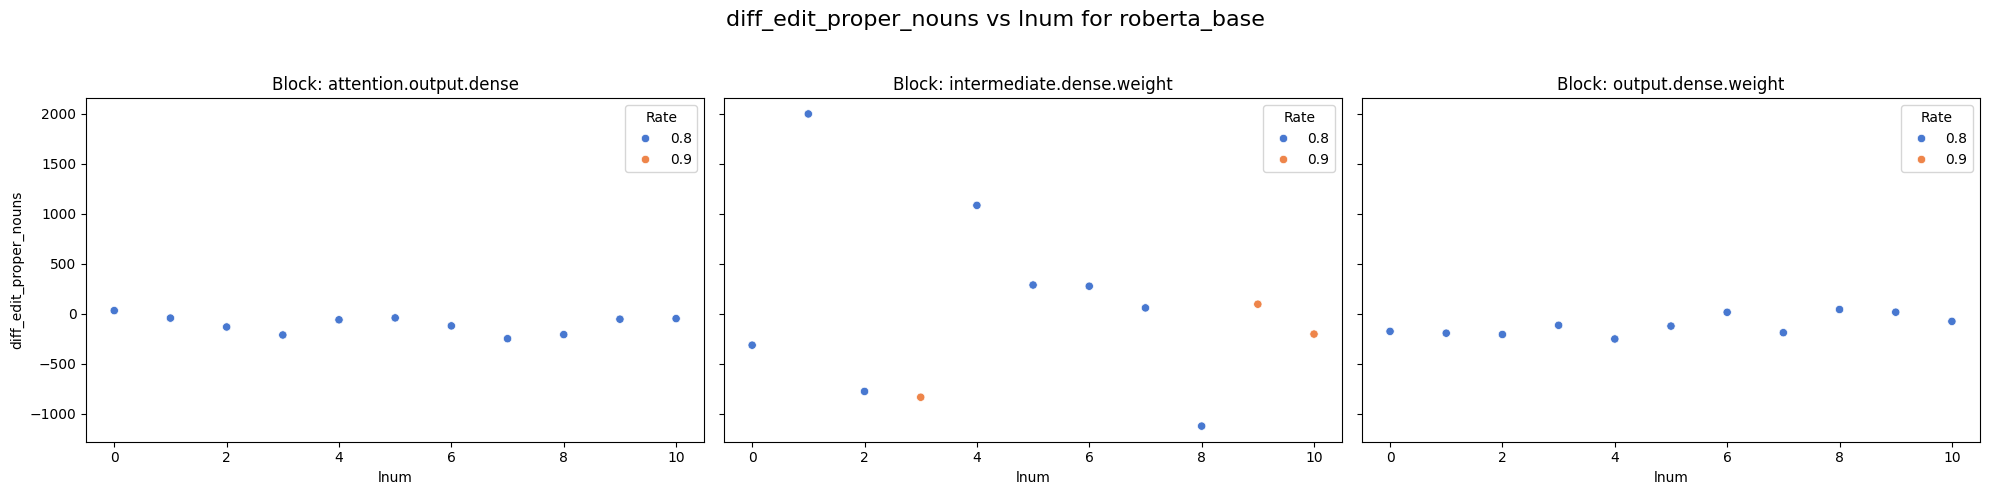

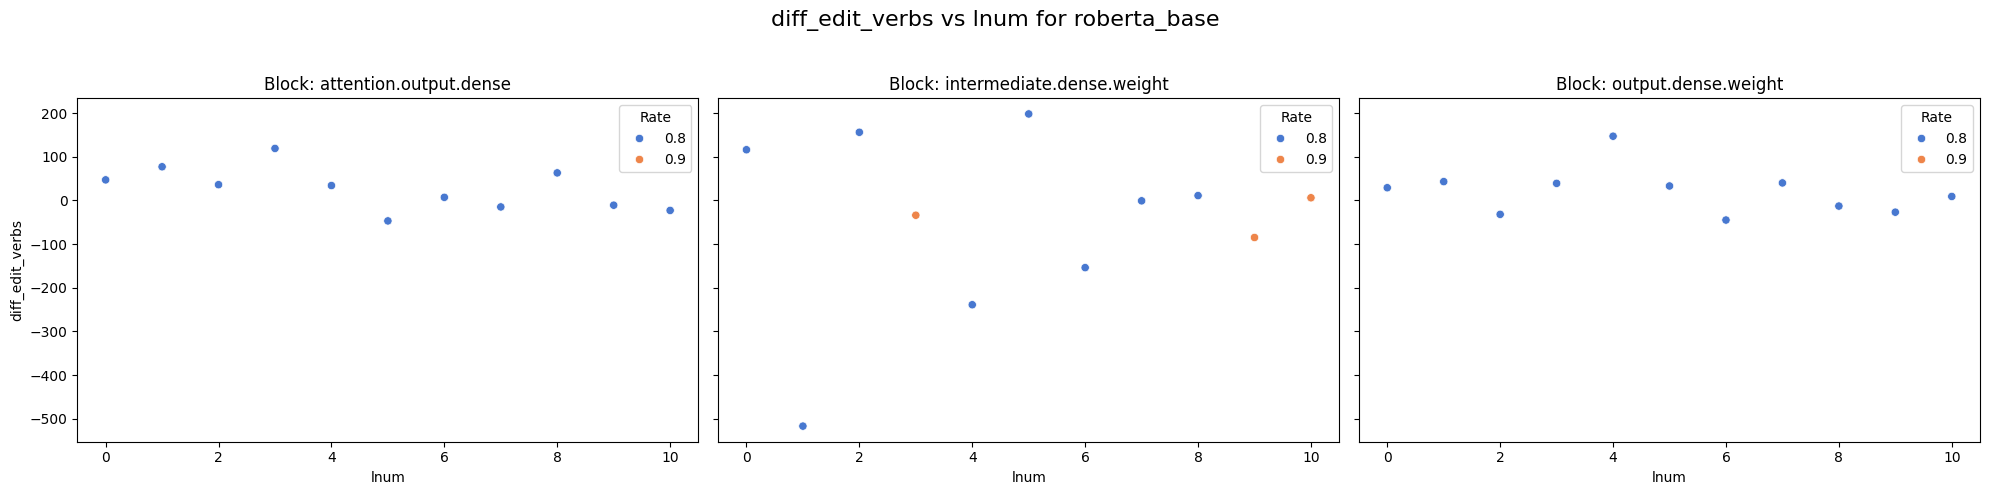

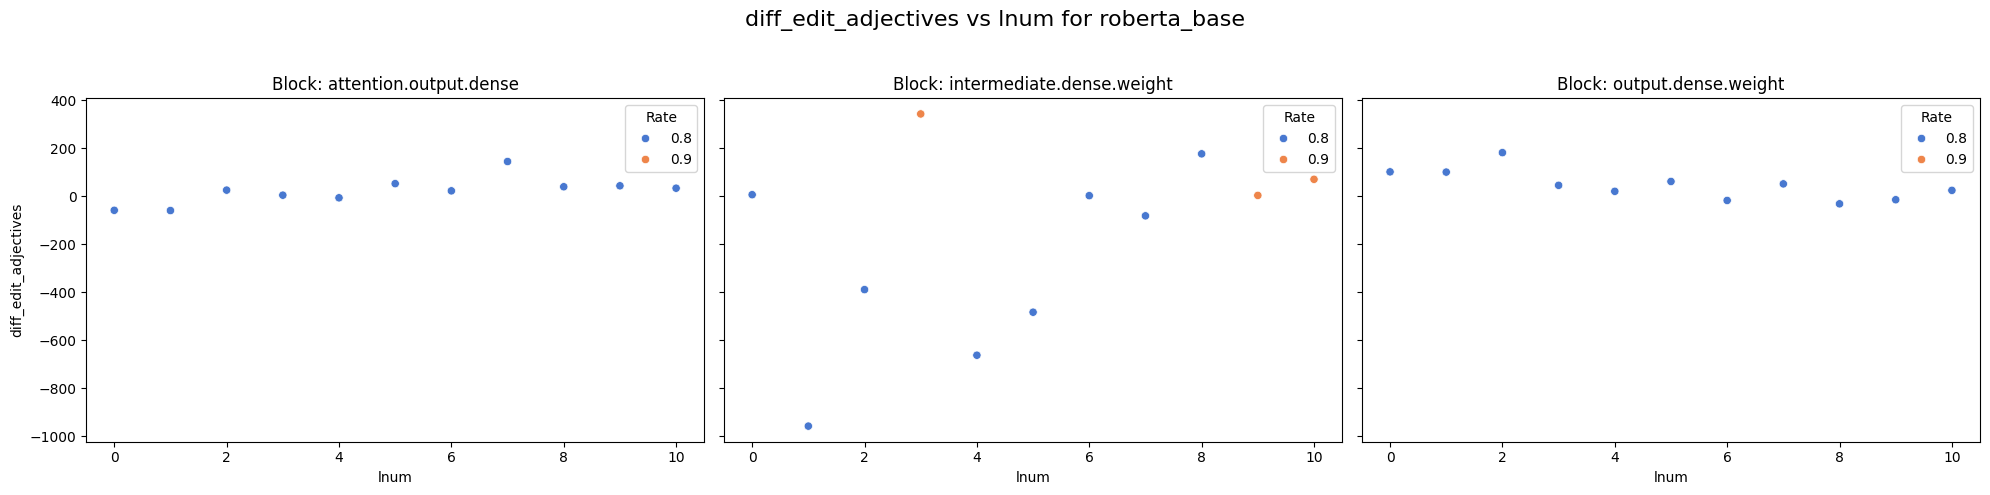

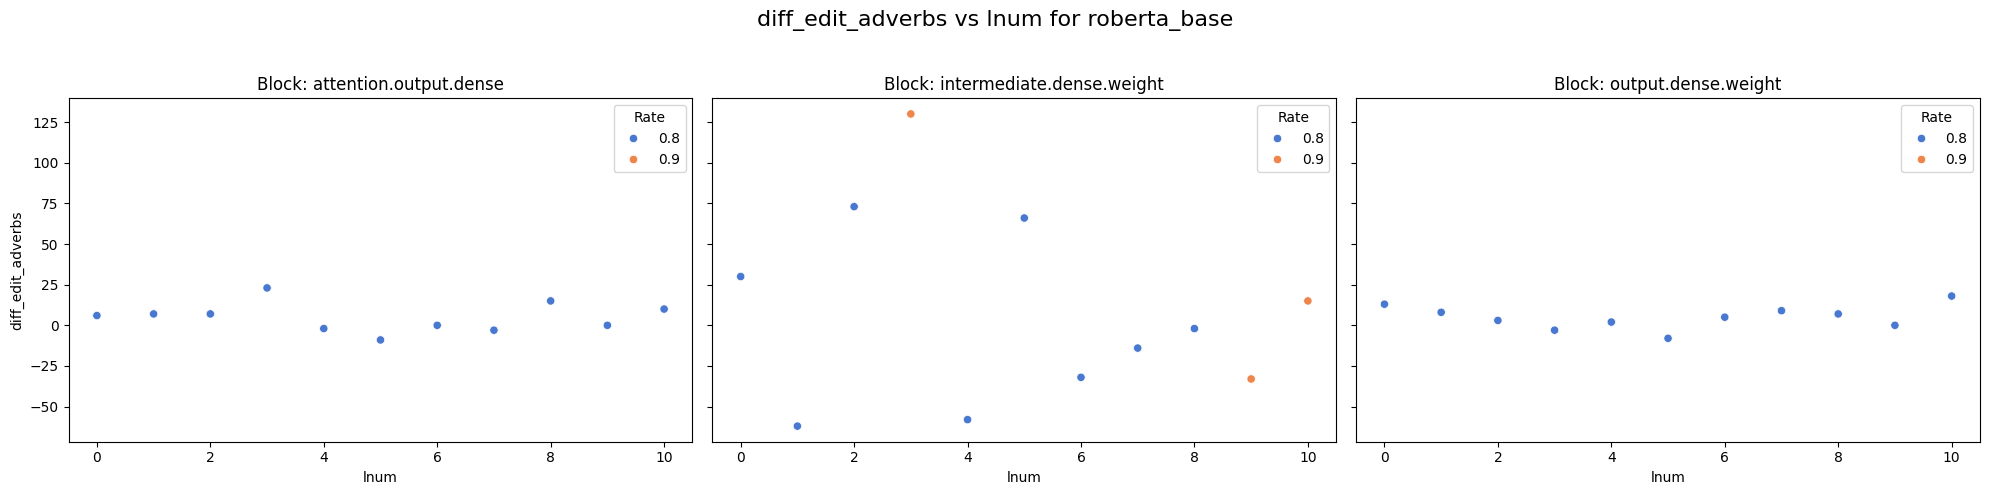

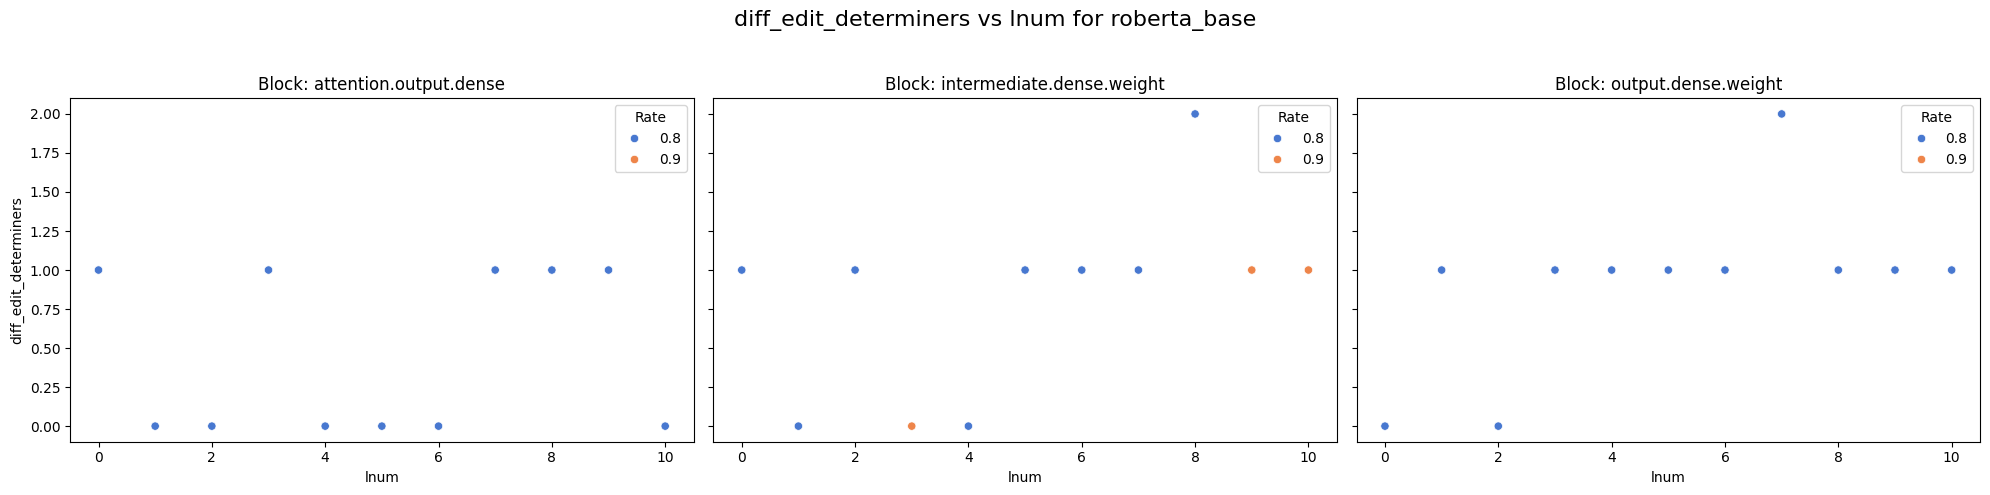

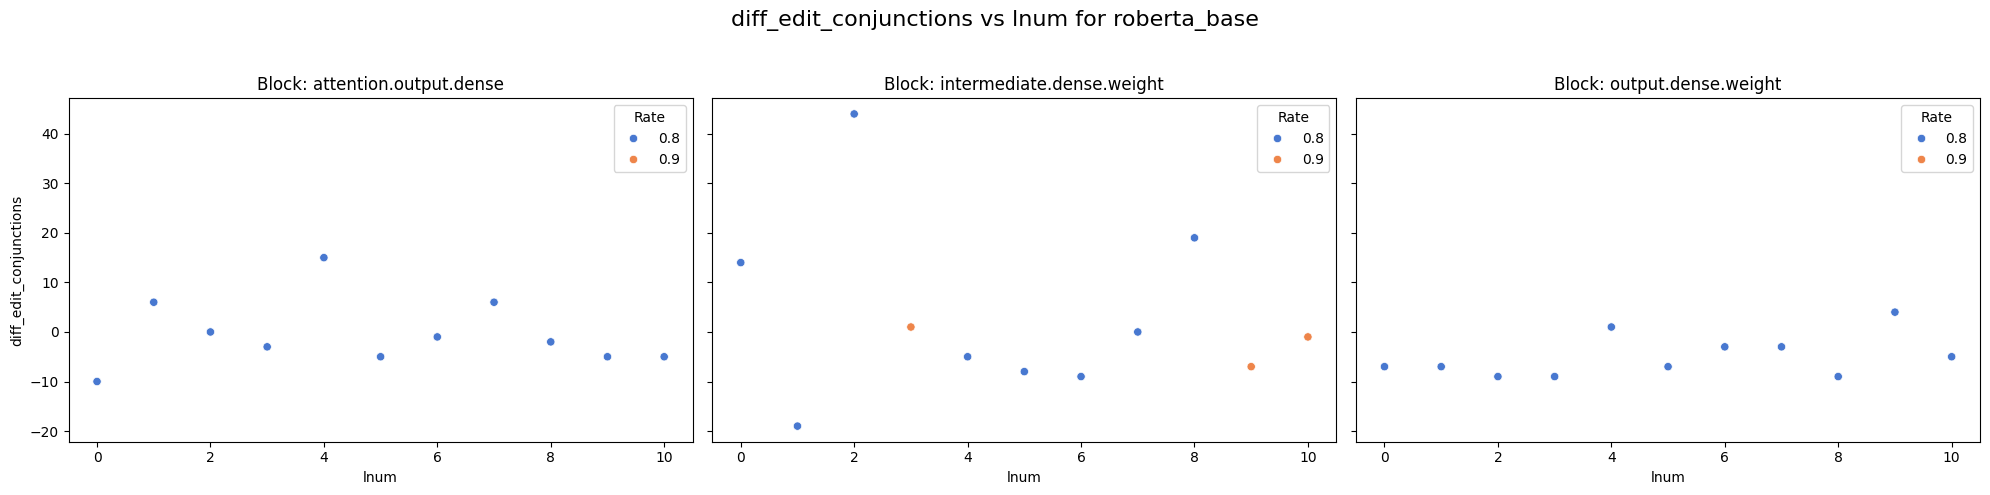

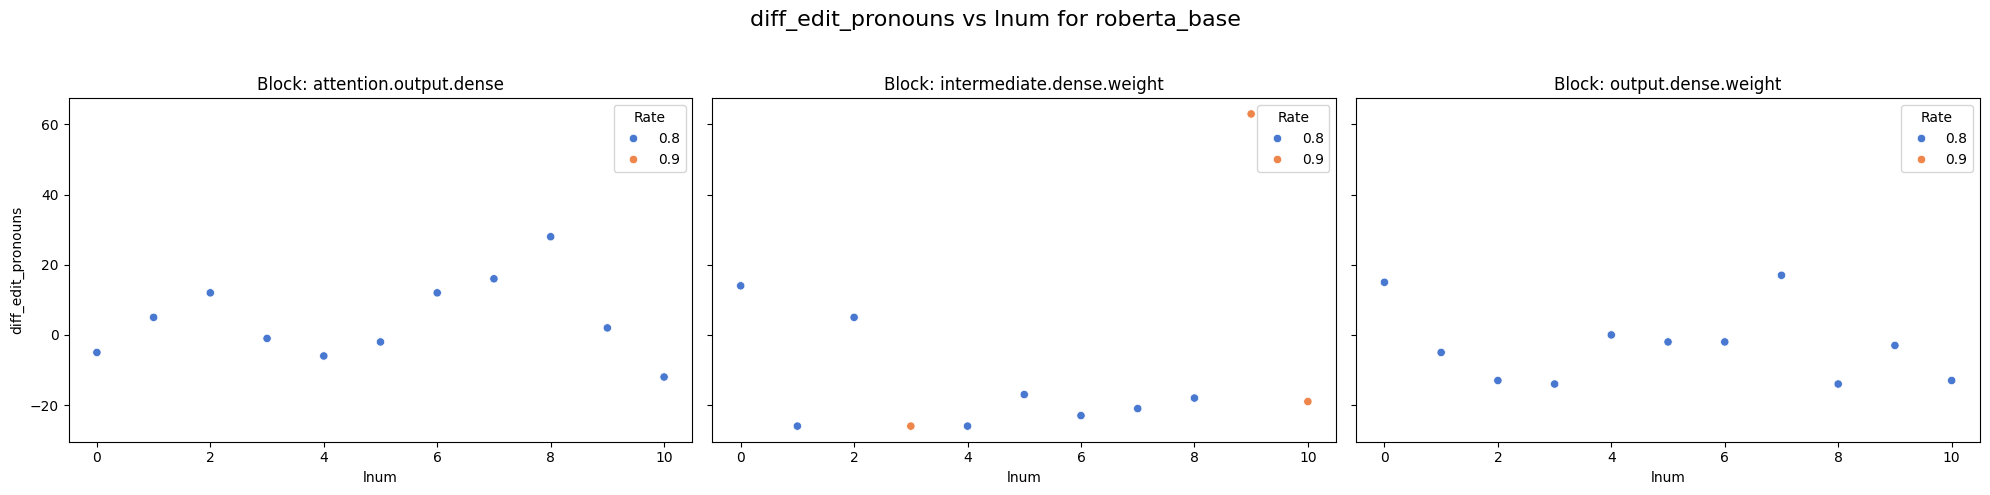

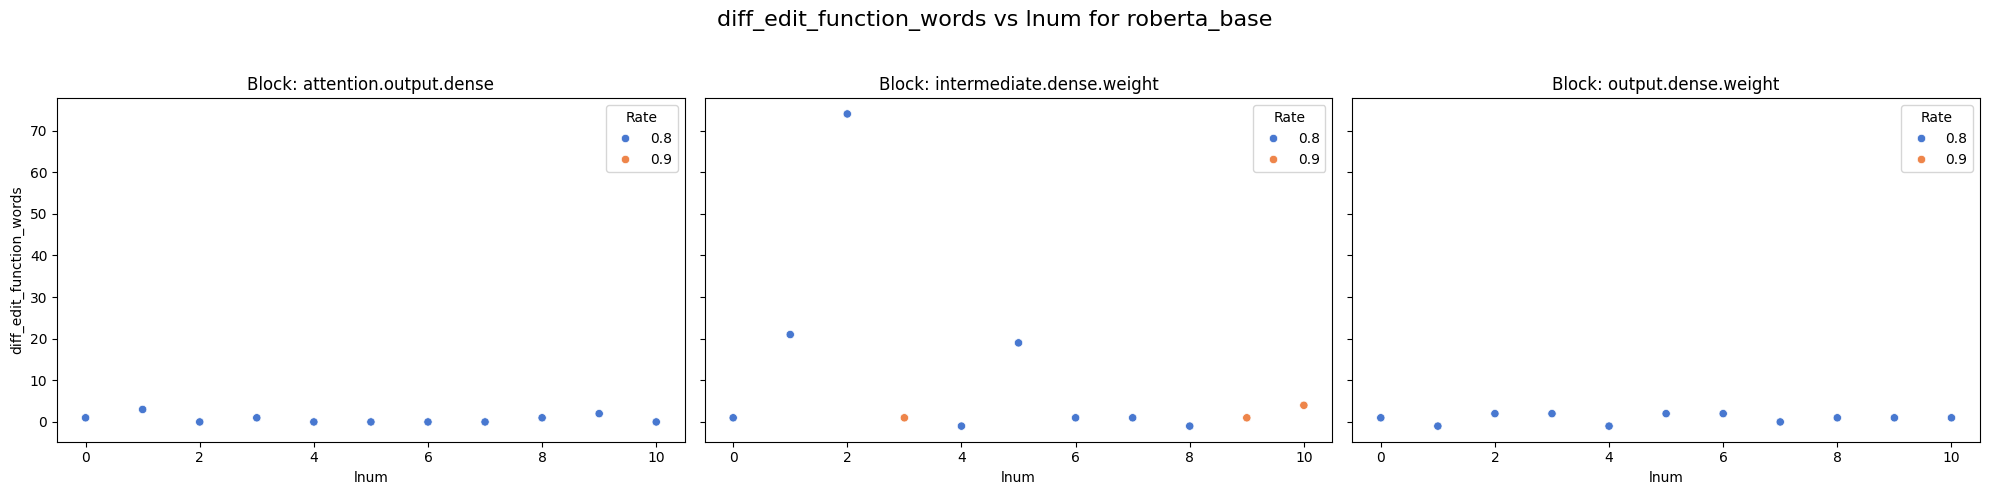

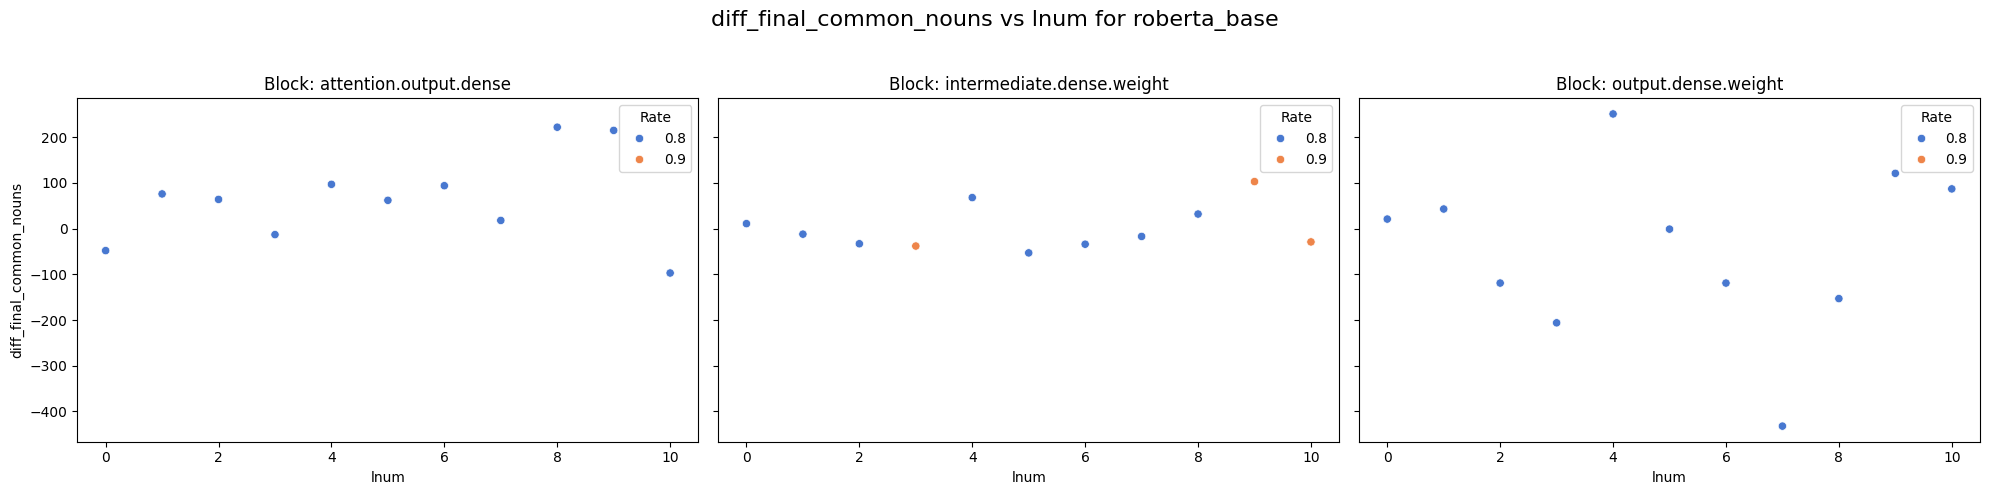

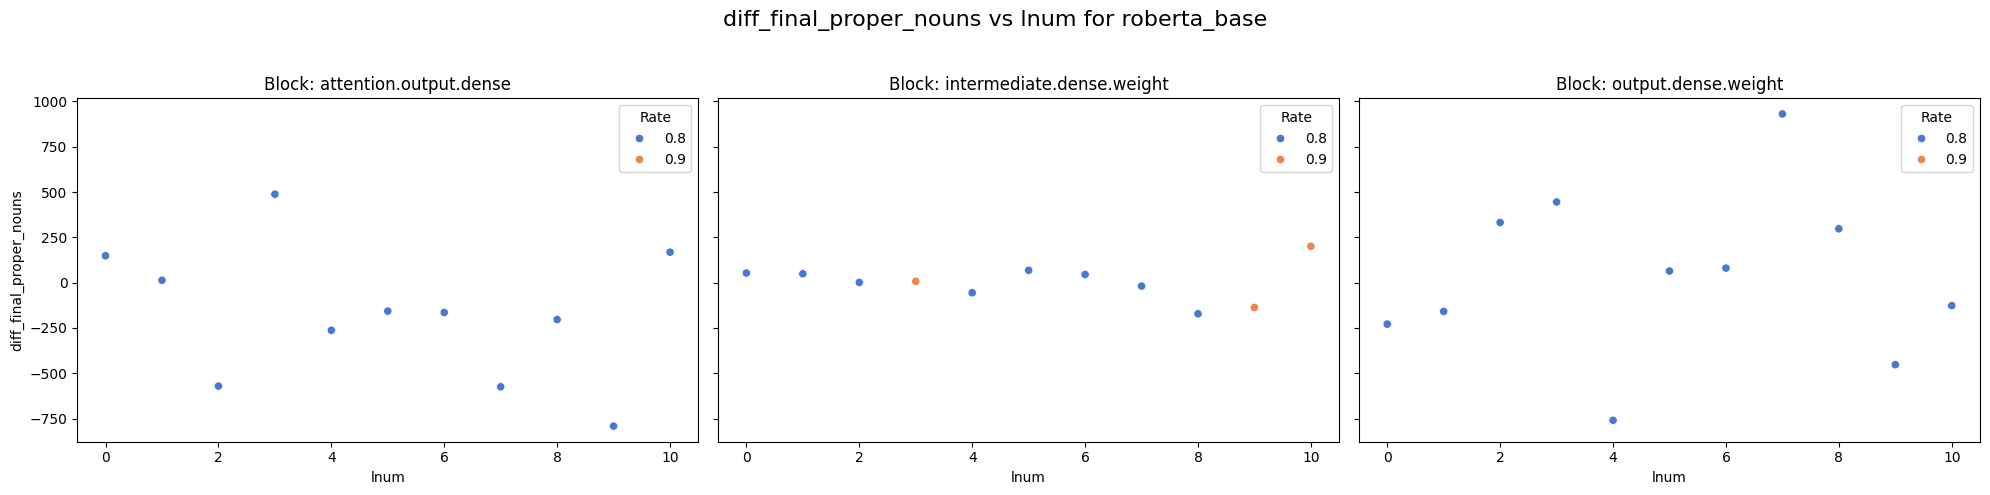

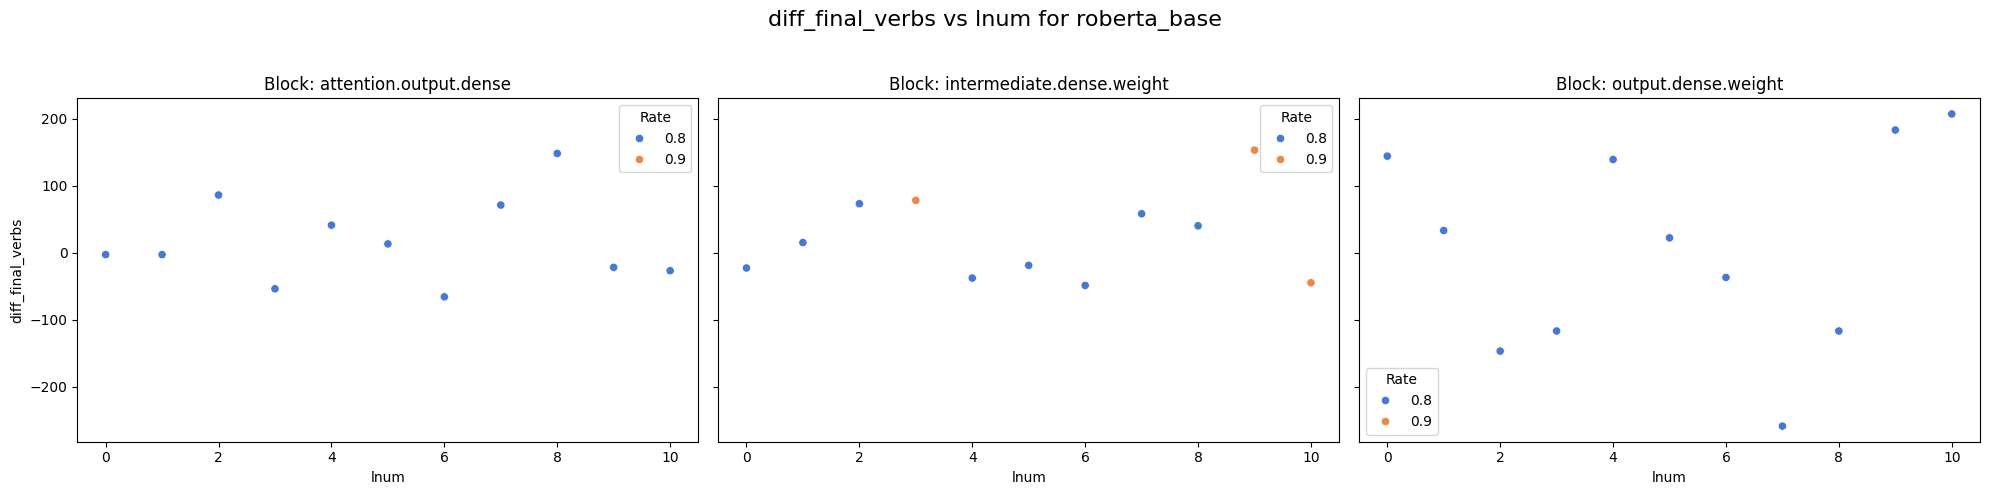

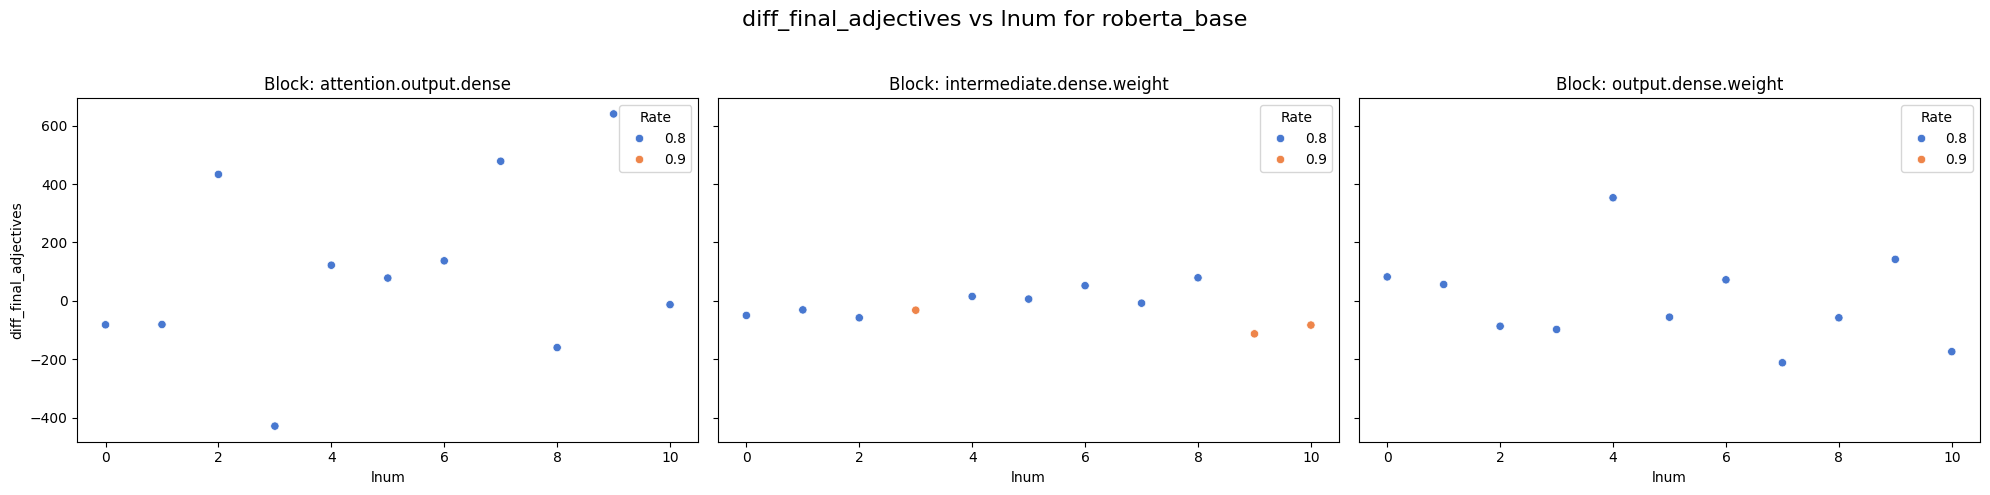

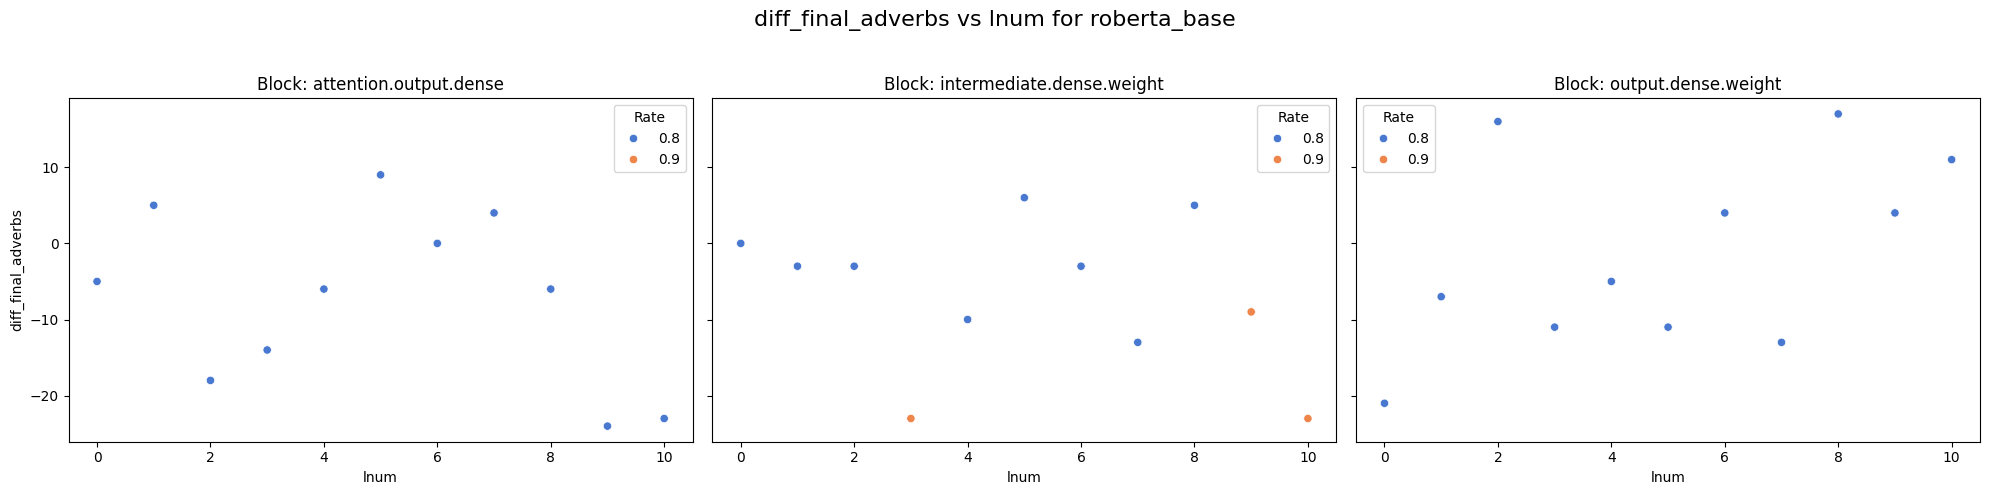

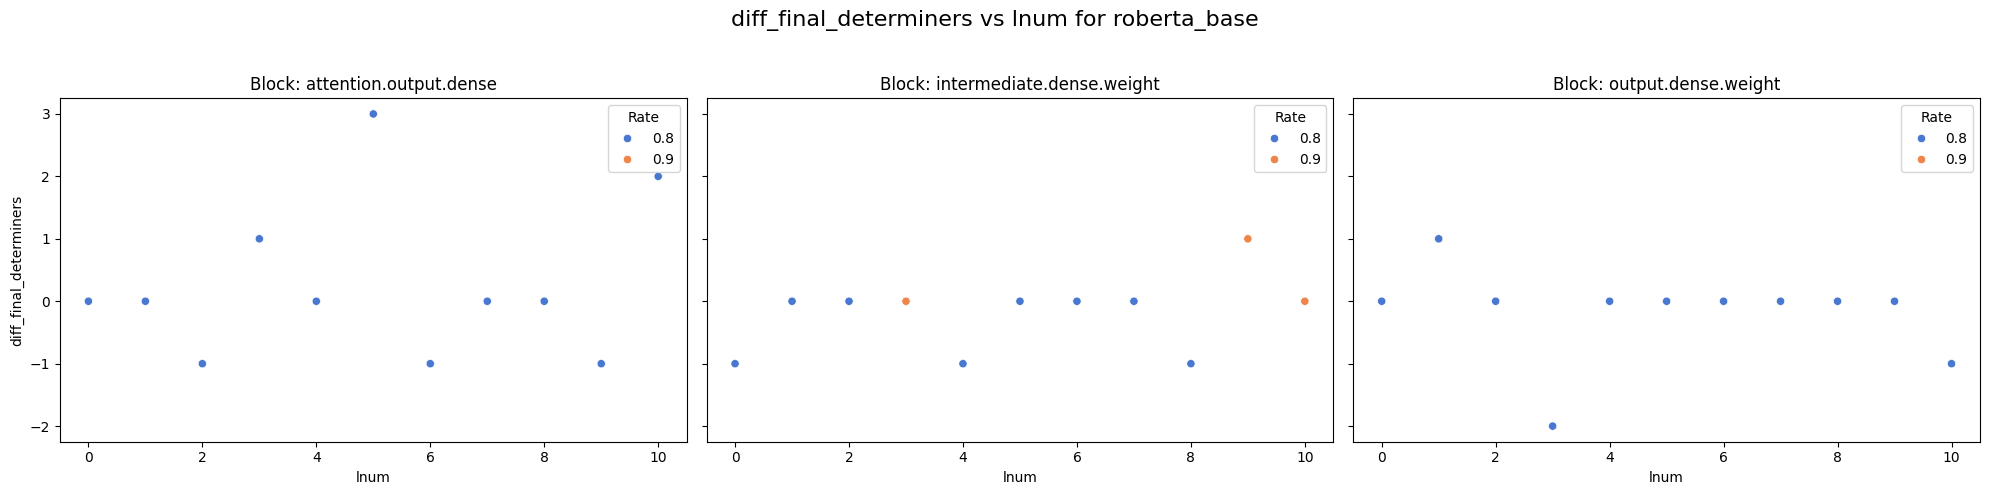

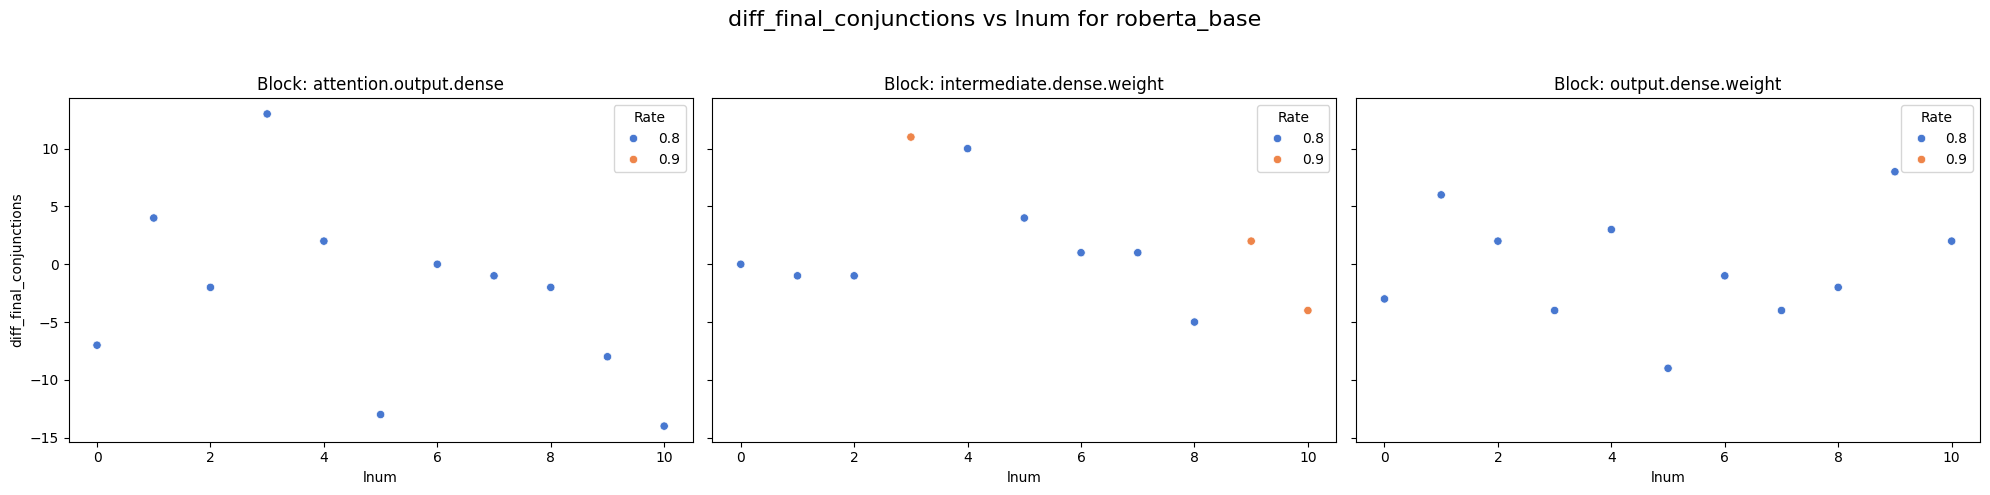

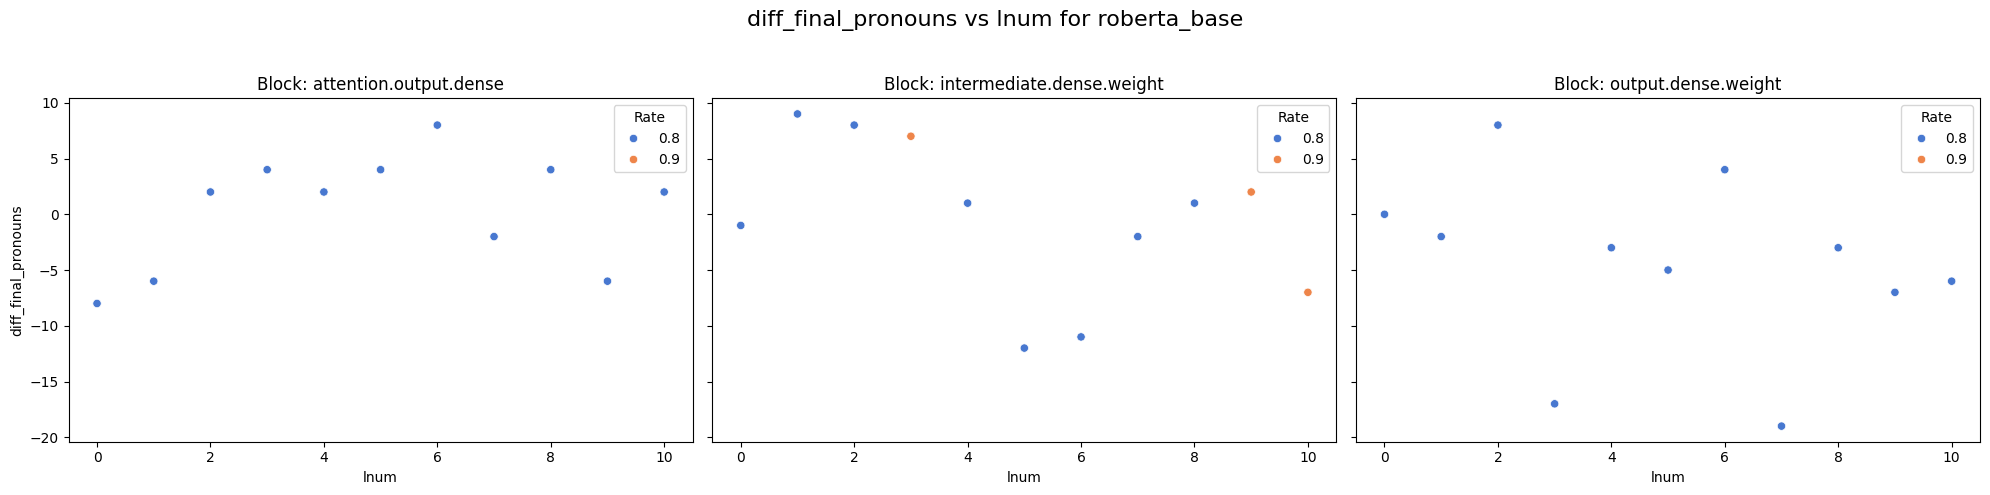

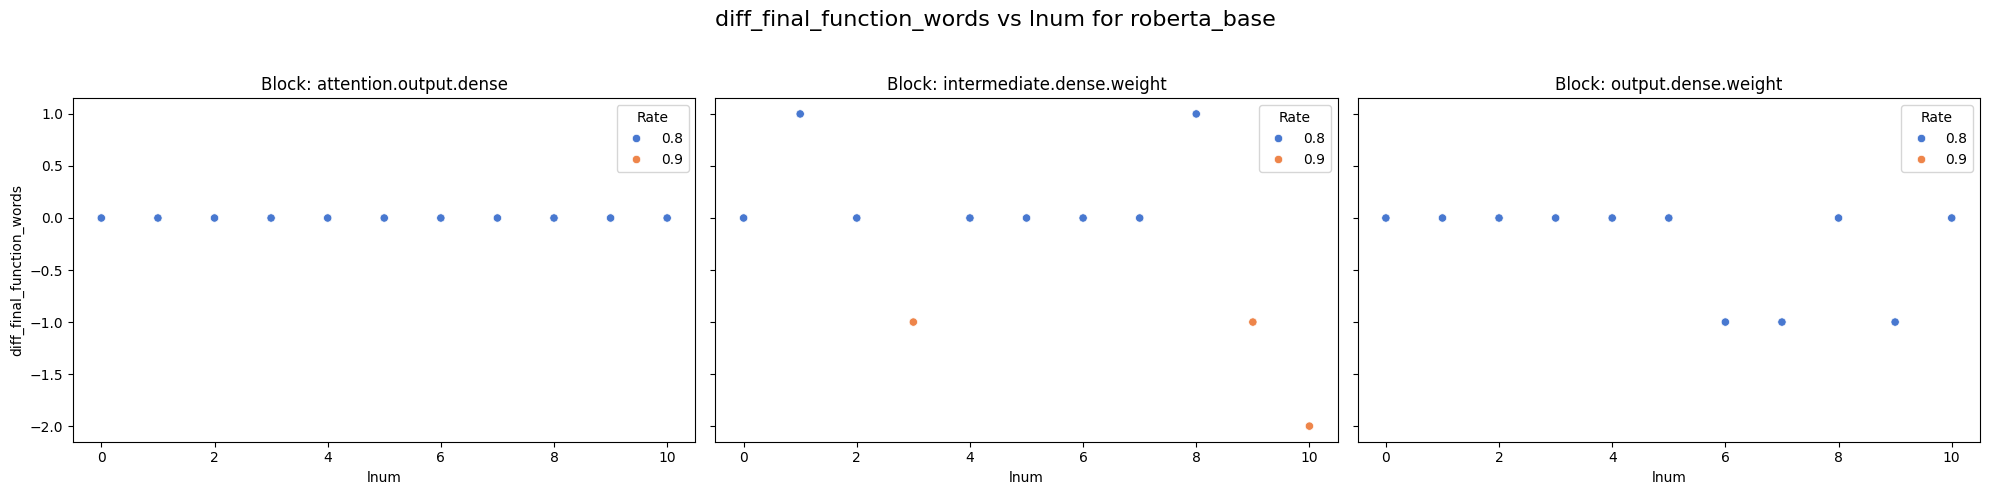

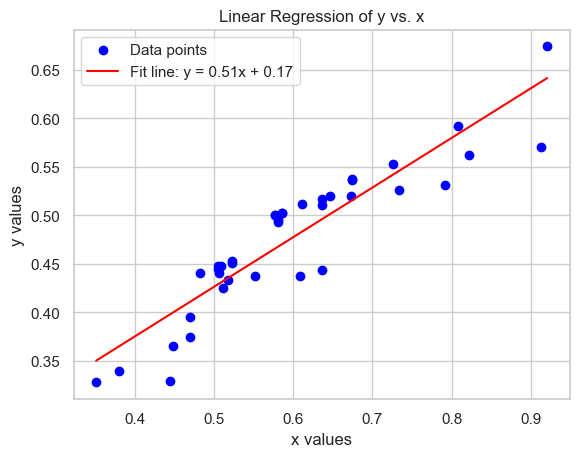

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define the full list of x and y values based on the provided data
x = np.array([
    0.470140061, 0.444682695, 0.470140061, 0.482777499, 0.351323813, 0.672856122,
    0.581033198, 0.504904421, 0.611265721, 0.581033198, 0.504904421, 0.67390544,
    0.586492693, 0.522681996, 0.635749806, 0.576759889, 0.635749806, 0.920434326,
    0.912131028, 0.608665237, 0.821448667, 0.79197652, 0.551804371, 0.67390544,
    0.808431042, 0.586492693, 0.733351582, 0.522681996, 0.511124291, 0.635749806,
    0.726416959, 0.576759889, 0.645954043, 0.508767127, 0.518226196, 0.44856061,
    0.506014569, 0.380035586
])

y = np.array([
    0.395529197, 0.329683698, 0.374695864, 0.440085158, 0.327706813, 0.520529197,
    0.494981752, 0.448296837, 0.51140511, 0.493309002, 0.444343066, 0.536192214,
    0.502585158, 0.452554745, 0.516879562, 0.500456204, 0.444190998, 0.674270073,
    0.570711679, 0.437804136, 0.562195864, 0.53086983, 0.4375, 0.537864964,
    0.592305353, 0.502585158, 0.525699513, 0.450577859, 0.424726277, 0.511100973,
    0.55276764, 0.500912409, 0.520225061, 0.447688565, 0.433850365, 0.36526764,
    0.440541363, 0.339568127
])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a range of x values for plotting the regression line
x_values = np.linspace(min(x), max(x), 100)
y_values = slope * x_values + intercept

# Plotting the data points
plt.scatter(x, y, color='blue', label='Data points')

# Plotting the regression line
plt.plot(x_values, y_values, color='red', label=f'Fit line: y = {slope:.2f}x + {intercept:.2f}')

# Add labels and title
plt.xlabel('x values')
plt.ylabel('y values')
plt.title('Linear Regression of y vs. x')

# Add a legend
plt.legend()

# Display the plot
plt.show()


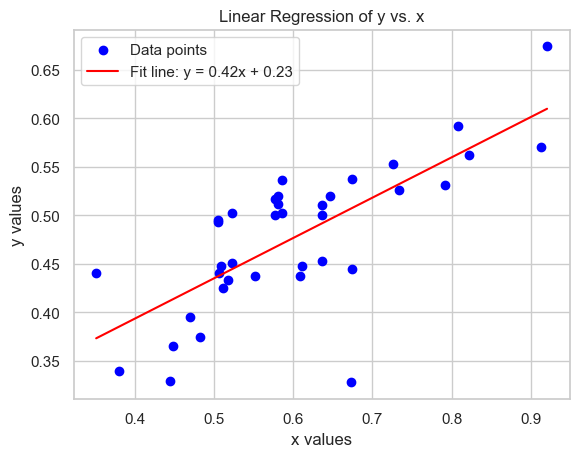

In [238]:
# Create a range of x values for plotting the regression line
x_values = np.linspace(min(x), max(x), 100)
y_values = slope * x_values + intercept

# Plotting the data points
plt.scatter(x, y, color='blue', label='Data points')

# Plotting the regression line
plt.plot(x_values, y_values, color='red', label=f'Fit line: y = {slope:.2f}x + {intercept:.2f}')

# Add labels and title
plt.xlabel('x values')
plt.ylabel('y values')
plt.title('Linear Regression of y vs. x')

# Add a legend
plt.legend()

# Display the plot
plt.show()